### Importing necessary packages and global constants

In [1]:
import multiprocessing
from multiprocessing import Pool
import pandas as pd
import os
import dask
import socket
from dask_jobqueue import SLURMCluster
from  distributed import Client
import subprocess
from dask import delayed, compute
import glob
import json
import numpy as np
import time
from sklearn.metrics import mean_squared_error  
import math  
import warnings
import pypandoc
import jiwer
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob
import utilityfuncs as util

warnings.simplefilter(action='ignore', category=FutureWarning)
!module load openmind/ffmpeg/20160310 
hfont = {'fontname':'Nimbus Sans'}
codebasenameoptions = ['yinruiqing', 'speechbox', 'ashraf', 'whisperx']  
codebase_mapping_dict = {1: 'yinruiqing', 2: 'speechbox', 3: 'ashraf',4: 'whisperx'}
codebase_count_mapping_dict = {'count_cb1': 'yinruiqing', 'count_cb2': 'speechbox', 'count_cb3': 'ashraf', 'count_cb4': 'whisperx'}

In [23]:
import importlib
import utilityfuncs as util
importlib.reload(util)

<module 'utilityfuncs' from '/weka/scratch/weka/cpl/arjunp/utilityfuncs.py'>

In [2]:
def createSwarmPlots(list_of_audio, list_of_gold_transcripts,unixtimes,special_dir = ""):
    length = len(list_of_audio)
    list_of_dfs = []

    for i in range (length):
        list_of_dfs.append(util.createFullDataframe(list_of_audio[i], list_of_gold_transcripts[i],unixtimes[i]))
    
    df = pd.concat(list_of_dfs)
    melted = pd.melt(df, value_vars=['count_cb1_residuals', 'count_cb2_residuals', 'count_cb3_residuals', 'count_cb4_residuals'],
                  var_name='value_name', value_name='counts', id_vars=['audio','status_cb1', 'status_cb2', 'status_cb3', 'status_cb4'])
    
    status= []
    for i in melted['counts']:
        if i>0:
            status.append('undercount')
        elif i<0:
            status.append('overcount')
        else:
            status.append('exact')

    melted['token_fate'] = status
    plt.figure(figsize=(8, 4))
    g = sns.FacetGrid(melted, col="value_name", row="audio",hue="token_fate", margin_titles=True, height=6, aspect=1  ,  palette={'undercount': 'blue', 'overcount': 'red', 'exact': 'green'})
    g.map(sns.swarmplot,  "counts",size=2.6,legend="full")
    g.set_titles(col_template="{col_name}", row_template="{row_name}" )
    plt.subplots_adjust(top=0.9)
    g.set_axis_labels("Residual", " ",fontsize=20)
    g.add_legend(title='Token fate',fontsize=16)
    g.fig.suptitle('Token count residuals per codebase, per audiofile',fontsize=24)
     
    name_of_plot = "swarm_"+unixtimes[0]+".pdf"
    if special_dir!="":
            name_of_plot = os.path.join(special_dir,name_of_plot )
    plt.savefig(name_of_plot, format='pdf')
    plt.show()


def createLogLogPlots(list_of_audio, list_of_gold_transcripts, unixtimes): #basically don't need this option anymore
    sns.set(font_scale=2.5)
    sns.set_style("white")
    length = len(list_of_audio)
    list_of_dfs = []

    for i in range (length):
        list_of_dfs.append(util.createFullDataframe(list_of_audio[i], list_of_gold_transcripts[i],unixtimes[i]))
    
    d1 = pd.concat(list_of_dfs)
    melted = pd.melt(d1, value_vars=['count_cb1', 'count_cb2', 'count_cb3', 'count_cb4'],
                  var_name='codebase', value_name='counts', id_vars=['audio','status_cb1', 'status_cb2', 'status_cb3', 'status_cb4'])

    melted['expected_counts'] = (list(d1['count_gold']) +   list(d1['count_gold']) + list(d1['count_gold'])  + list(d1['count_gold']) )
    melted['log(counts)'] = np.log(melted['counts']+1)
    melted['log(expected_counts)'] = np.log(melted['expected_counts']+1)
    g = sns.FacetGrid(melted, col="codebase", row="audio", margin_titles=True, height=12, aspect=1 )
    g.map(sns.scatterplot,   'log(expected_counts)',  'log(counts)', label = 'token',legend='full',alpha=0.3,color='black')
    g.map(sns.lineplot, 'log(expected_counts)', 'log(expected_counts)', color='red', linestyle ='--',legend='full',label='identity line')
    plt.subplots_adjust(top=0.9)
    g.set_axis_labels("Log(expected counts)", "Log(model counts)",fontsize=30)
    g.fig.suptitle('Log transformed: Expected vs model counts',fontsize=34)
    g.add_legend( )
    g.set_titles(col_template="{col_name}", row_template="{row_name}" )
    plt.show()


def createLogKDEPlots(list_of_audio, list_of_gold_transcripts, unixtimes,special_dir = ""):  
    plt.figure()
    with sns.plotting_context("notebook", font_scale=2.5):
    #sns.set(font_scale=2.5)
        sns.set_style("white")
    
        length = len(list_of_audio)
        list_of_dfs = []

        for i in range (length):
            list_of_dfs.append(util.createFullDataframe(list_of_audio[i], list_of_gold_transcripts[i],unixtimes[i]))
        
        d1 = pd.concat(list_of_dfs)
        
        melted = pd.melt(d1, value_vars=['count_cb1', 'count_cb2', 'count_cb3', 'count_cb4'],
                    var_name='codebase', value_name='counts', id_vars=['audio','status_cb1', 'status_cb2', 'status_cb3', 'status_cb4'])

        melted['expected_counts'] = (list(d1['count_gold']) +   list(d1['count_gold']) + list(d1['count_gold'])  + list(d1['count_gold']) )
        melted['log(counts)'] = np.log(melted['counts']+1)
        melted['log(expected_counts)'] = np.log(melted['expected_counts']+1)
        df_for_facet  = (melted.groupby(['codebase','audio','log(counts)','log(expected_counts)']).agg({'counts':['size']})).reset_index()
        unrolled_df = df_for_facet.loc[df_for_facet.index.repeat(df_for_facet['counts']['size'])].reset_index(drop=True)
        unrolled_df['codebase_name'] = unrolled_df['codebase'].map(codebase_count_mapping_dict)
        g = sns.FacetGrid(unrolled_df, col="codebase_name", row="audio", margin_titles=True, height=12, aspect=1,col_order=codebasenameoptions)
        g.map(sns.kdeplot,  'log(expected_counts)',   'log(counts)',  fill=True, thresh=0, levels=80, cmap="mako",bw_method=0.4)
        g.map(sns.lineplot, 'log(expected_counts)', 'log(expected_counts)', color='orange', linestyle ='--',legend='full',label='Ideal case')
        g.add_legend()
        plt.subplots_adjust(top=0.98)
        g.set_axis_labels("Log(expected counts)", "Log(model counts)")#,fontsize=30)
        g.fig.suptitle('Log transformed: model counts vs expected counts',**hfont,  weight='bold',size=50)  
        g.set_titles(col_template="Codebase : {col_name}", row_template="{row_name}" )
        for ax in g.axes.flat:
            #ax.set_yticks(np.arange(0,2.1,0.2))
            #ax.set_xticks(metrics,labels=metrics_labels,**hfont,rotation=20) 
            ax.set_xlabel("Log(expected counts)",fontsize=30, **hfont)
            ax.set_ylabel("Log(model counts)",fontsize=30, **hfont)


        name_of_plot = "logKDE_"+unixtimes[0]+".png"
        if special_dir!="":
            name_of_plot = os.path.join(special_dir,name_of_plot )
        plt.savefig(name_of_plot, format='png')
        plt.show()
        return d1


#abandoned below style --- graveyard cell
'''def createFreqPlots(list_of_audio, list_of_gold_transcripts, sources):
    length = len(list_of_audio)
    list_of_dfs = []

    for i in range (length):
        list_of_dfs.append(createFullDataframe(list_of_audio[i], list_of_gold_transcripts[i], sources[i]))
    
    d1  = pd.concat(list_of_dfs)
    melted = pd.melt(d1, value_vars=['count_cb1', 'count_cb2', 'count_cb3', 'count_cb4'],
                  var_name='value_name', value_name='counts', id_vars=['audio','status_cb1', 'status_cb2', 'status_cb3', 'status_cb4'])
    melted['expected_counts'] = (list(d1['count_gold']) +   list(d1['count_gold']) + list(d1['count_gold'])  + list(d1['count_gold']) )
    g = sns.FacetGrid(melted, col="value_name", row="audio", margin_titles=True, height=6, aspect=1.5)
    g.map(sns.scatterplot,   'expected_counts',  'counts', label = 'token')
    g.map(sns.lineplot, 'expected_counts', 'expected_counts', color='red', linestyle ='--',legend='auto',label='identity line')
    plt.subplots_adjust(top=0.9)
    g.set_axis_labels("Expected counts", "Model counts",fontsize=20)
    g.fig.suptitle('Expected vs model counts per codebase, per audiofile',fontsize=24)
    g.add_legend(fontsize=14)
    for ax in g.axes.flat:
        leg = ax.get_legend()
        if leg is not None:
            for text in leg.get_texts():
                text.set_fontsize(14)   
    plt.show()    '''

'def createFreqPlots(list_of_audio, list_of_gold_transcripts, sources):\n    length = len(list_of_audio)\n    list_of_dfs = []\n\n    for i in range (length):\n        list_of_dfs.append(createFullDataframe(list_of_audio[i], list_of_gold_transcripts[i], sources[i]))\n    \n    d1  = pd.concat(list_of_dfs)\n    melted = pd.melt(d1, value_vars=[\'count_cb1\', \'count_cb2\', \'count_cb3\', \'count_cb4\'],\n                  var_name=\'value_name\', value_name=\'counts\', id_vars=[\'audio\',\'status_cb1\', \'status_cb2\', \'status_cb3\', \'status_cb4\'])\n    melted[\'expected_counts\'] = (list(d1[\'count_gold\']) +   list(d1[\'count_gold\']) + list(d1[\'count_gold\'])  + list(d1[\'count_gold\']) )\n    g = sns.FacetGrid(melted, col="value_name", row="audio", margin_titles=True, height=6, aspect=1.5)\n    g.map(sns.scatterplot,   \'expected_counts\',  \'counts\', label = \'token\')\n    g.map(sns.lineplot, \'expected_counts\', \'expected_counts\', color=\'red\', linestyle =\'--\',legend=\'

### Main function to create any kind of plot

In [36]:
def createLatestPlots(kind,special_dir="",latest_timestamp =""):
    ''' 
    Function to create plots after pulling data from the latest run of the pipeline (i.e. the last UNIX timestamp)
    '''
    if latest_timestamp == "":
        latest_timestamp, list_of_filepaths, list_of_files, list_of_audio, list_of_gold_transcripts = util.prepareMyData()
    else:
        latest_dummy,list_of_filepaths, list_of_files, list_of_audio, list_of_gold_transcripts = util.prepareMyData(latest_timestamp)

    unixtimes = [latest_timestamp]*len(list_of_files)

    fulldf = None
    if kind == 'word-counts-swarm':
        fulldf = createSwarmPlots(list_of_audio, list_of_gold_transcripts,unixtimes,special_dir)

    elif kind == 'word-counts-logdensity':
        fulldf = createLogKDEPlots(list_of_audio, list_of_gold_transcripts,unixtimes,special_dir)

    elif kind == 'speaker-counts-swarm':
        fulldf = speakerCountsPlots(special_dir,latest_timestamp)
    
    elif kind == 'speaker-counts-violin':
        fulldf = speakerCountsViolinPlots(special_dir,latest_timestamp)   

    elif kind == 'wer':
        fulldf = createWERheatmap(special_dir,latest_timestamp)

    elif kind == 'word-counts-rmse':
        fulldf = createRMSEheatmap(special_dir,latest_timestamp)

    elif kind == 'audio-errors':
        fulldf = createAudioErrorsPlots(special_dir,latest_timestamp)

    elif kind == 'error-rate-swarm':
        fulldf = createSwarmErrorRatePlots(special_dir,latest_timestamp)

    elif kind == 'error-rate-facet':
        fulldf = createErrorFacetPlots(special_dir,latest_timestamp)

    elif kind == 'missing-speakers':
        fulldf = speakerMissingCountsPlots(special_dir,latest_timestamp)

    elif kind == 'speaker-counts-heat':
        fulldf = speakerCountsHeat(special_di,latest_timestamp)
    else:
        print("Invalid kind of plot. Please choose from 'speaker-counts-heat','missing-speakers', 'audio-errors', 'error-rate-swarm', 'wer','word-counts-rmse', 'speaker-counts-swarm', 'speaker-counts-violin','word-counts-logdensity' or 'word-counts-swarm'")

    return fulldf 
    

### RMSE analysis

In [32]:
def calculateRMSELatest(latest_timestamp=""):
    '''
    Function to calculate the Root Mean Square Error (RMSE) for the latest run of the pipeline
    Each (codebase, audiofile) pair has a RMSE score
    '''
    latest_timestamp, list_of_filepaths, list_of_files, list_of_audio, list_of_gold_transcripts = util.prepareMyData(latest_timestamp)
     
    N = len(list_of_files)

    cb_df = []
    audio_df = []
    rmse_df = []


    #iterate over dataframe rows as dicts 
    #use df for all functions 
 
    for i in range(N):
        c = util.createFullDataframe(list_of_audio[i], list_of_gold_transcripts[i], latest_timestamp)
        j=1+codebasenameoptions.index((os.path.basename(os.path.split(list_of_filepaths[i])[0])))
        actual = c['count_gold'].to_list()
        predicted = c[f'count_cb{j}'].to_list()
        mse = mean_squared_error(actual, predicted)
        rmse = (mse)**(1/2)
        rmse_df.append(rmse)
        cb_df.append(j)
        audio_df.append(list_of_audio[i])


    df   = pd.DataFrame(list(zip(cb_df, audio_df, rmse_df)), columns =['codebase', 'audio', 'RMSE'])
    df.to_csv('RMSE_'+latest_timestamp+'.csv', index=False)
    return df 


def createRMSEheatmap(special_dir="",latest_timestamp=""):
    hfont = {'fontname':'Nimbus Sans'}
    rmse_df = calculateRMSELatest(latest_timestamp)
    plt.figure(figsize=(10,7))

    pivoted_df = rmse_df.pivot(index = "audio", columns = "codebase", values="RMSE")
    
    pivoted_df.columns = codebasenameoptions
    ax= sns.heatmap(pivoted_df, cmap="crest",annot=True )
    plt.title("RMSE on token types",fontsize=14, **hfont,weight='bold')
    plt.xlabel("Codebase",fontsize=12, **hfont)
    plt.ylabel("Audio file name",fontsize=12, **hfont)
    plt.xticks(**hfont)
    plt.yticks(**hfont)
    name_of_plot = 'RMSE_heatmap.pdf'
    if special_dir!="":
                name_of_plot = os.path.join(special_dir,name_of_plot )
    plt.savefig(name_of_plot, format='pdf',bbox_inches='tight')
    plt.show()
    return rmse_df


### WER analysis

In [8]:
def calculateWERLatest(latest_timestamp=""):
    '''
    Function to calculate the Word Error Rate (WER) for the latest run of the pipeline
    Each (codebase, audiofile) pair has a WER score, SR, IR, DR, HR
    '''

    latest_timestamp, list_of_filepaths, list_of_files, list_of_audio, list_of_gold_transcripts = util.prepareMyData(latest_timestamp)
    
    cb_df = []
    wer_df = []
    subs = []
    ins = []
    hits = []
    dels = []
    N = len(list_of_filepaths)
    
    for i in range(N):
            referencedf = pd.read_csv(list_of_gold_transcripts[i])
            hypodf = pd.read_csv(list_of_filepaths[i])
            reference = referencedf['text'].str.cat(sep=' ')
            hypothesis = hypodf['text'].str.cat(sep=' ')
            out = jiwer.process_words(jiwer.RemovePunctuation()(reference).lower(), jiwer.RemovePunctuation()(hypothesis).lower())
            wer_df.append(out.wer)
            cb_df.append(1+codebasenameoptions.index(os.path.basename(os.path.split(list_of_filepaths[i])[0])))
             
            subs.append(out.substitutions)
            ins.append(out.insertions)
            hits.append(out.hits)
            dels.append(out.deletions)


    df   = pd.DataFrame(list(zip(cb_df, list_of_audio, wer_df, subs, dels, ins,hits)), columns =['codebase', 'audio', 'WER','substitutions','deletions','insertions','hits'])
    df['N_ref'] = df['substitutions'] + df['deletions'] + df['hits']
    df['substitution_rate'] = df['substitutions']/df['N_ref'] 
    df['deletion_rate'] = df['deletions']/df['N_ref']
    df['insertion_rate'] = df['insertions']/df['N_ref']
    df['hit_rate'] = df['hits']/df['N_ref']
    df.to_csv('WER_'+latest_timestamp+'.csv', index=False)
    return df 

def createWERheatmap(special_dir="",latest_timestamp=""):
    wer_df = calculateWERLatest(latest_timestamp)
    plt.figure(figsize=(10,8))
    pivoted_df = wer_df.pivot(index =  "audio" , columns = "codebase", values="WER")
     
    pivoted_df.columns = codebasenameoptions

    ax= sns.heatmap(pivoted_df, cmap="crest",annot=True)
    #ax.set(xlabel="Codebase", ylabel="Audio file name",**hfont)
    plt.xlabel("Codebase",fontsize=12, **hfont)
    plt.ylabel("Audio file name",fontsize=12, **hfont)
    plt.xticks(**hfont)
    plt.yticks(**hfont)
    plt.title("WER across each audio file",weight='bold',**hfont,size=14)
    name_of_plot = "WER_heatmap.pdf"
    if special_dir!="":
            name_of_plot = os.path.join(special_dir,name_of_plot )
    plt.savefig(name_of_plot, format='pdf',bbox_inches='tight')
    plt.show()
    for i in pivoted_df.columns:
        print("Mean WER for codebase", i,"is",pivoted_df[i].mean())
    return wer_df

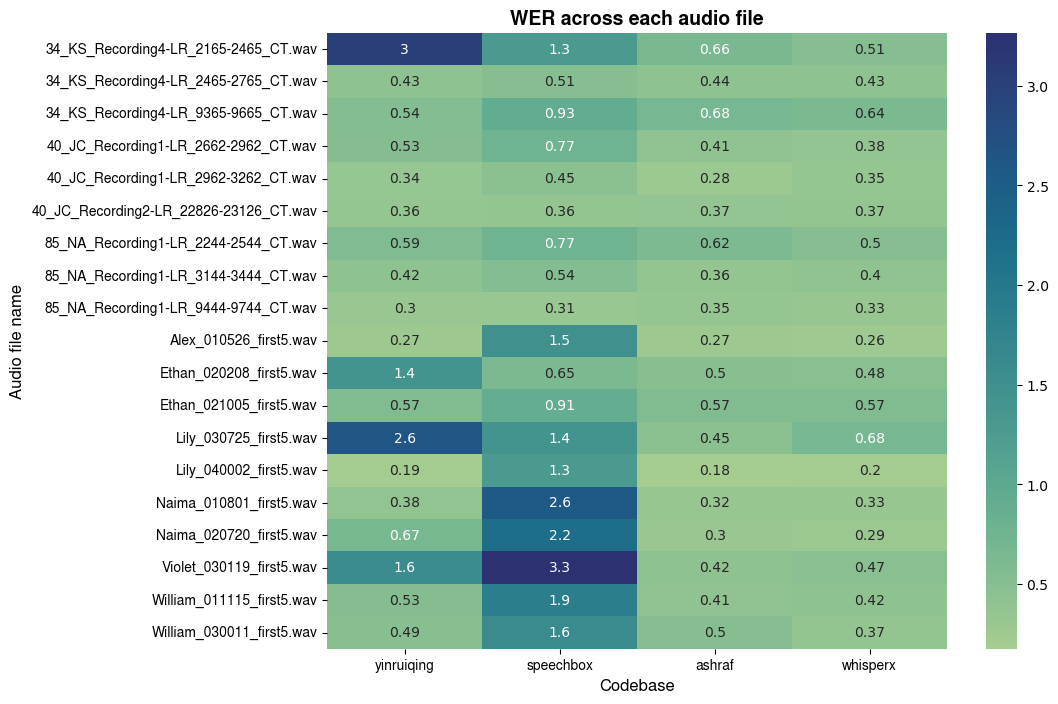

Mean WER for codebase yinruiqing is 0.8051428485217117
Mean WER for codebase speechbox is 1.2230756013936817
Mean WER for codebase ashraf is 0.42652010843571936
Mean WER for codebase whisperx is 0.41914583868565075


,codebase,audio,WER,substitutions,deletions,insertions,hits,N_ref,substitution_rate,deletion_rate,insertion_rate,hit_rate
0,4,34_KS_Recording4-LR_9365-9665_CT.wav,0.640732,84,128,68,225,437,0.192220,0.292906,0.155606,0.514874
1,4,Alex_010526_first5.wav,0.260000,9,29,1,112,150,0.060000,0.193333,0.006667,0.746667
2,4,William_030011_first5.wav,0.366129,67,147,13,406,620,0.108065,0.237097,0.020968,0.654839
3,4,85_NA_Recording1-LR_2244-2544_CT.wav,0.504065,139,44,3,186,369,0.376694,0.119241,0.008130,0.504065
4,4,40_JC_Recording1-LR_2962-3262_CT.wav,0.349887,53,94,8,296,443,0.119639,0.212190,0.018059,0.668172
...,...,...,...,...,...,...,...,...,...,...,...,...
71,2,William_011115_first5.wav,1.871460,428,0,431,31,459,0.932462,0.000000,0.938998,0.067538
72,2,40_JC_Recording1-LR_2962-3262_CT.wav,0.453725,101,42,58,300,443,0.227991,0.094808,0.130926,0.677201
73,2,40_JC_Recording2-LR_22826-23126_CT.wav,0.363239,72,26,68,359,457,0.157549,0.056893,0.148796,0.785558
74,2,34_KS_Recording4-LR_2465-2765_CT.wav,0.513131,100,27,127,368,495,0.202020,0.054545,0.256566,0.743434


In [9]:
createWERheatmap(special_dir='/om/user/arjunp/baseline-smallen-plots',latest_timestamp = '1727565010')

In [69]:
wer_df = calculateWERLatest()
wer_df.groupby('codebase').agg({'WER': 'mean'})


,WER
codebase,
1,0.406608
2,1.000569
3,0.387240
4,0.404317


In [43]:
plt.rcdefaults()
sns.reset_defaults()

In [38]:
def createAudioErrorsPlots(special_dir="",latest_timestamp=""):
    wer_df = calculateWERLatest(latest_timestamp)
    wer_df.columns =  ['codebase', 'audio', 'WER', 'substitutions', 'deletions', 'insertions',
       'hits', 'N_ref', 'Substitution rate', 'Deletion rate', 'Insertion rate',
       'Hit rate']
    melted_wer_df = pd.melt(wer_df, id_vars=['codebase','audio'], value_vars=['Substitution rate', 'Deletion rate', 'Insertion rate','Hit rate'], var_name='performance metric', value_name='value')
    melted_wer_df['source'] = np.where(melted_wer_df['audio'].str[-5:]=="5.wav","Providence corpus","LENA dataset")
    melted_wer_df['codebase_name'] = melted_wer_df['codebase'].map(codebase_mapping_dict)
    plt.figure()
    g = sns.catplot(data=melted_wer_df, x="value", y='audio' , hue="performance metric", col="codebase_name", col_order=codebasenameoptions ,col_wrap=2,aspect=1 , height=7,kind ='strip',palette=[ 'blueviolet','red','orange', 'green'],legend_out=True)
    name_of_plot = "audiowise_errors.pdf"


    #g._legend.set_title("Performance Metric",prop={'family': 'Nimbus Sans', 'size': 18})
    plt.suptitle("Detailed view of per-audio performance", size=22, **hfont,weight='bold')
    plt.subplots_adjust(top=0.9)
    
    for ax in g.axes.flat:
        ax.set_xticks(np.arange(0,2.1,0.5))
        #ax.set_yticks(**hfont) 
        #ax.set_yticklabels(ax.get_yticks(), fontsize=14)
        ax.set_ylabel("Name of audio",size=20, **hfont)
        ax.set_xlabel("Value",size=20, **hfont)
        #ax.text(1.05, 0.5 , "Ideal hit rate line",rotation=0, **hfont,color='green')
        plt.setp(ax.get_yticklabels(), **hfont,size=16)

    for ax in g.axes.flat:
        ax.axvline(x=1, color='green', linestyle='--', linewidth=1, label='Ideal hit rate line')

    for text in g._legend.get_texts():
        text.set_fontfamily('Nimbus Sans') 
        text.set_fontsize(14)  
    g.set_titles(col_template="{col_name} codebase" , **hfont,size=18)
    plt.legend(prop={'family': 'Nimbus Sans','size':16},bbox_to_anchor=(1.05, 1),loc='upper left')
    g._legend.remove()

    if special_dir!="":
            name_of_plot = os.path.join(special_dir,name_of_plot )
    plt.savefig(name_of_plot, format='pdf',bbox_inches='tight')
    
    plt.show()
    return melted_wer_df

/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

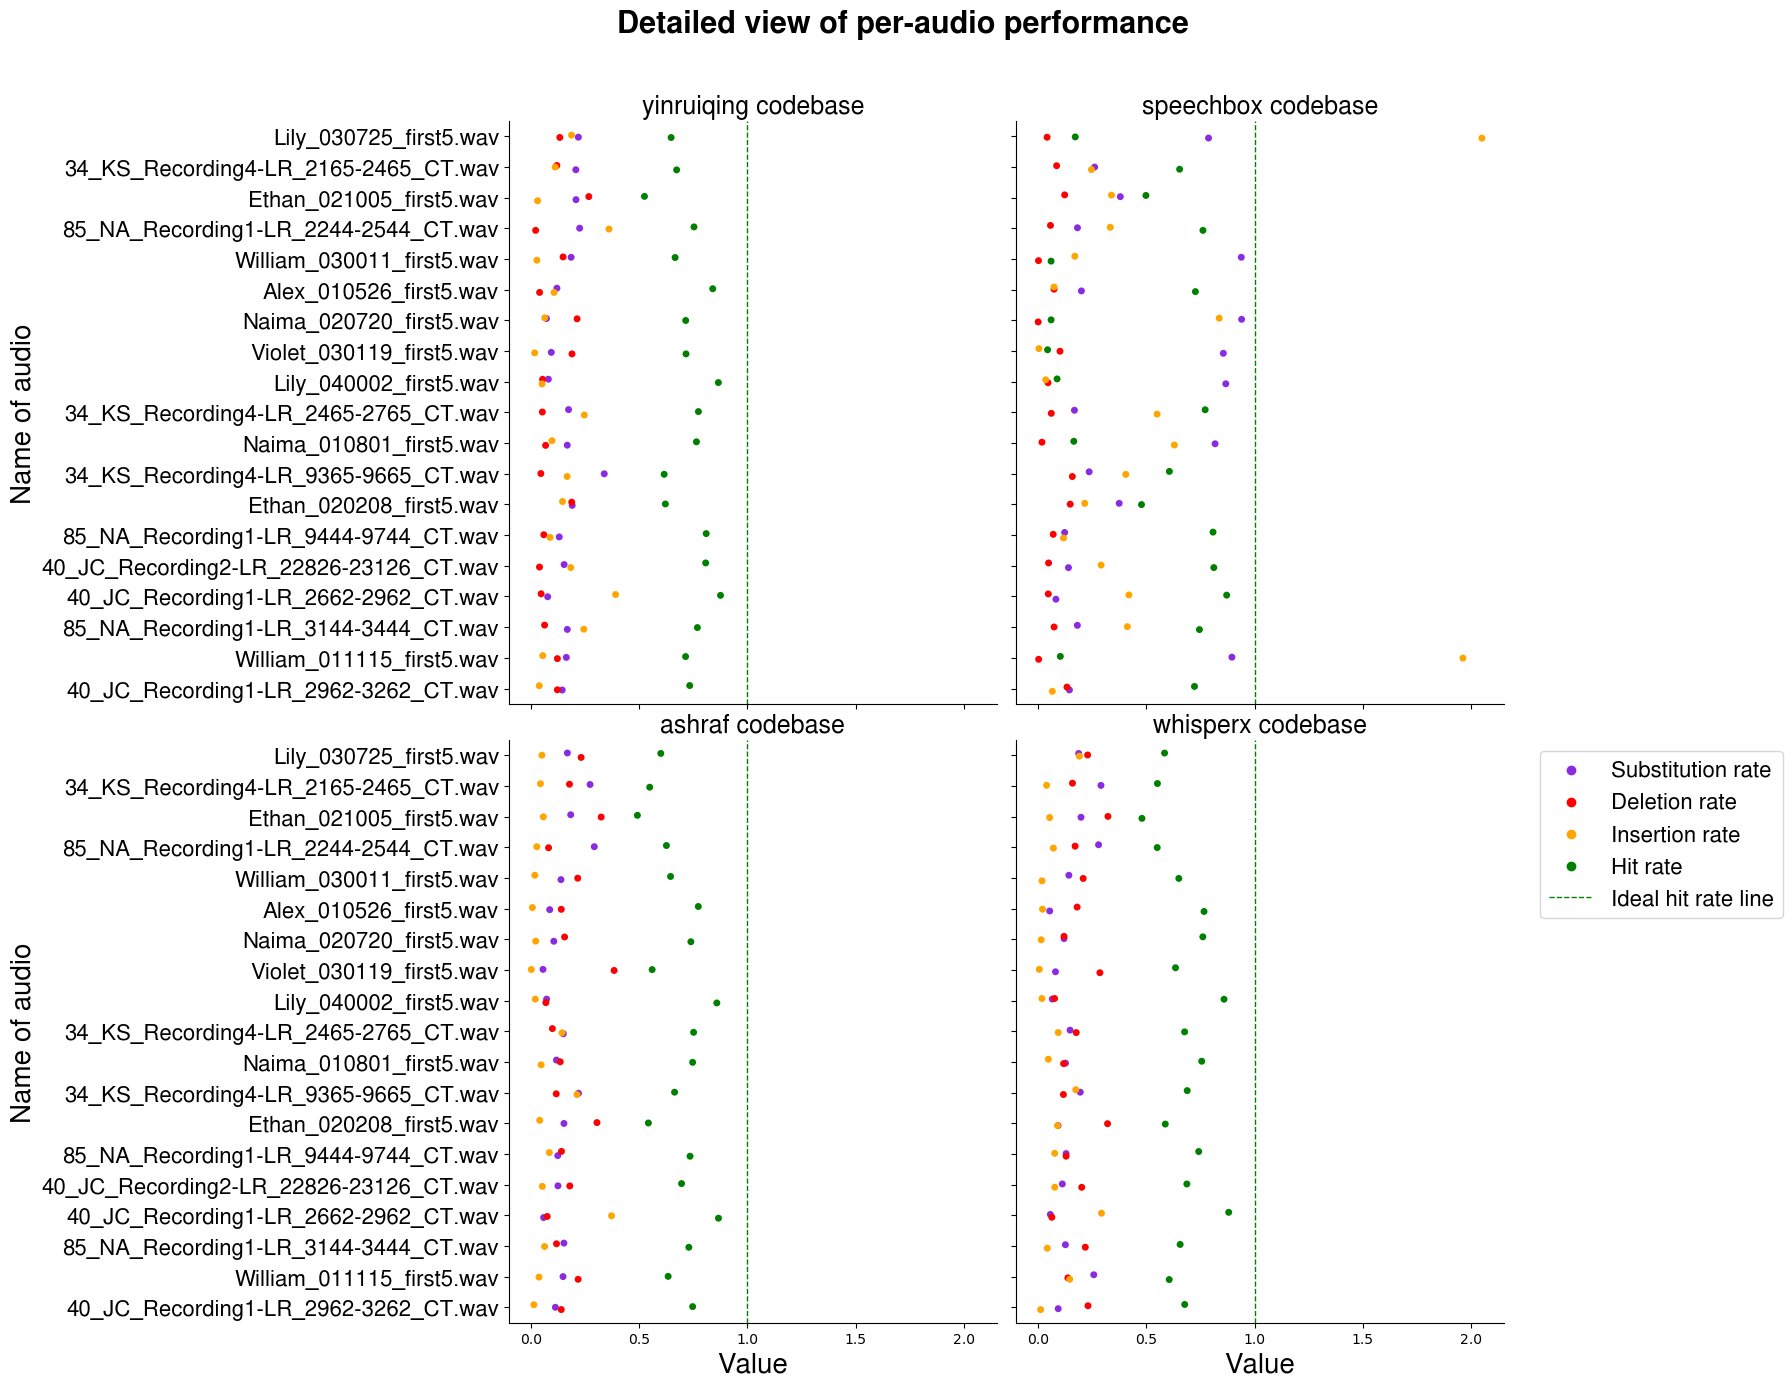

,codebase,audio,performance metric,value,source,codebase_name
0,3,Lily_030725_first5.wav,Substitution rate,0.168254,Providence corpus,ashraf
1,3,34_KS_Recording4-LR_2165-2465_CT.wav,Substitution rate,0.273171,LENA dataset,ashraf
2,3,Ethan_021005_first5.wav,Substitution rate,0.183673,Providence corpus,ashraf
3,3,85_NA_Recording1-LR_2244-2544_CT.wav,Substitution rate,0.292683,LENA dataset,ashraf
4,3,William_030011_first5.wav,Substitution rate,0.138710,Providence corpus,ashraf
...,...,...,...,...,...,...
299,1,Naima_020720_first5.wav,Hit rate,0.715139,Providence corpus,yinruiqing
300,1,Alex_010526_first5.wav,Hit rate,0.840000,Providence corpus,yinruiqing
301,1,40_JC_Recording1-LR_2662-2962_CT.wav,Hit rate,0.875878,LENA dataset,yinruiqing
302,1,Violet_030119_first5.wav,Hit rate,0.716522,Providence corpus,yinruiqing


In [220]:
createAudioErrorsPlots()

In [39]:
def createErrorFacetPlots(special_dir="",latest_timestamp=""):
    plt.figure()
    wer_df = calculateWERLatest(latest_timestamp)
    melted_wer_df = pd.melt(wer_df, id_vars=['codebase','audio'], value_vars=['substitution_rate', 'deletion_rate','insertion_rate','hit_rate'], var_name='performance metric', value_name='value')
    melted_wer_df['source'] = np.where(melted_wer_df['audio'].str[-5:]=="5.wav","Providence corpus","LENA dataset")
    melted_wer_df['codebase_name'] = melted_wer_df['codebase'].map(codebase_mapping_dict)
    g = sns.catplot(data=melted_wer_df, x="performance metric", y='value', hue="performance metric", col="codebase_name",col_order=codebasenameoptions, row="source", aspect=1,kind ='strip',palette=['orange','red','blue','green'] ,jitter=0.2, s=15)
    for ax in g.axes.flat:
        ax.set_yticks(np.arange(0,2.1,0.1))
    plt.suptitle("Error analysis across datasets",weight='bold')
    plt.subplots_adjust(top=0.9)

    name_of_plot = "error_rate_facet.pdf"
    if special_dir!="":
            name_of_plot = os.path.join(special_dir,name_of_plot)
    plt.savefig(name_of_plot, format='pdf',bbox_inches='tight')

    plt.show()
    return melted_wer_df

In [ ]:
# Dont need this in report
createErrorFacetPlots()

In [40]:
def createSwarmErrorRatePlots(special_dir="",latest_timestamp=""):
    wer_df = calculateWERLatest(latest_timestamp)
    metrics = ['substitution_rate', 'deletion_rate','insertion_rate','hit_rate']
    metrics_labels = ['Substitution rate', 'Deletion rate','Insertion rate','Hit rate']
    melted_wer_df = pd.melt(wer_df, id_vars=['codebase','audio'], value_vars= metrics, var_name='performance metric', value_name='value')
    melted_wer_df['source'] = np.where(melted_wer_df['audio'].str[-5:]=="5.wav","Providence corpus","LENA dataset")
    melted_wer_df['codebase_name'] = melted_wer_df['codebase'].map(codebase_mapping_dict)
    plt.figure( )
    g = sns.catplot(data=melted_wer_df, x="performance metric", y='value', hue="source", col="codebase_name", col_order=codebasenameoptions,col_wrap=4,aspect=0.85,kind ='swarm',palette=['purple','orange'] , s=40,height=6)
    g._legend.remove()
    for ax in g.axes.flat:
        ax.set_yticks(np.arange(0,2.1,0.2),labels = [round(i,1) for i in np.arange(0,2.1,0.2)],size=16,**hfont)
        ax.set_xticks(metrics,labels=metrics_labels,**hfont,rotation=40,size=20) 
        ax.set_xlabel("Performance metric",fontsize=22, **hfont)
        ax.set_ylabel("Value",fontsize=22, **hfont)

    #g._legend.set_title("Dataset",prop={'family': 'Nimbus Sans'})
    plt.suptitle("Performance of each codebase on each audio",  size=27, **hfont,weight='bold')
    plt.subplots_adjust(top=0.8)
    for ax in g.axes.flat:
        ax.axhline(y=1, color='gray', linestyle='--', linewidth=1, label='Ideal for hit rate' )
    plt.legend(prop={'family': 'Nimbus Sans','size':16},bbox_to_anchor=(1.05, 1),loc='upper left')
    #for text in g._legend.get_texts():
    #    text.set_fontfamily('Nimbus Sans')   
    g.set_titles(col_template="{col_name} codebase" , **hfont, size=22)
    name_of_plot = "error_rate_swarm.pdf"
    if special_dir!="":
            name_of_plot = os.path.join(special_dir,name_of_plot )
    plt.savefig(name_of_plot, format='pdf',bbox_inches='tight')
    plt.show()

    return melted_wer_df

/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

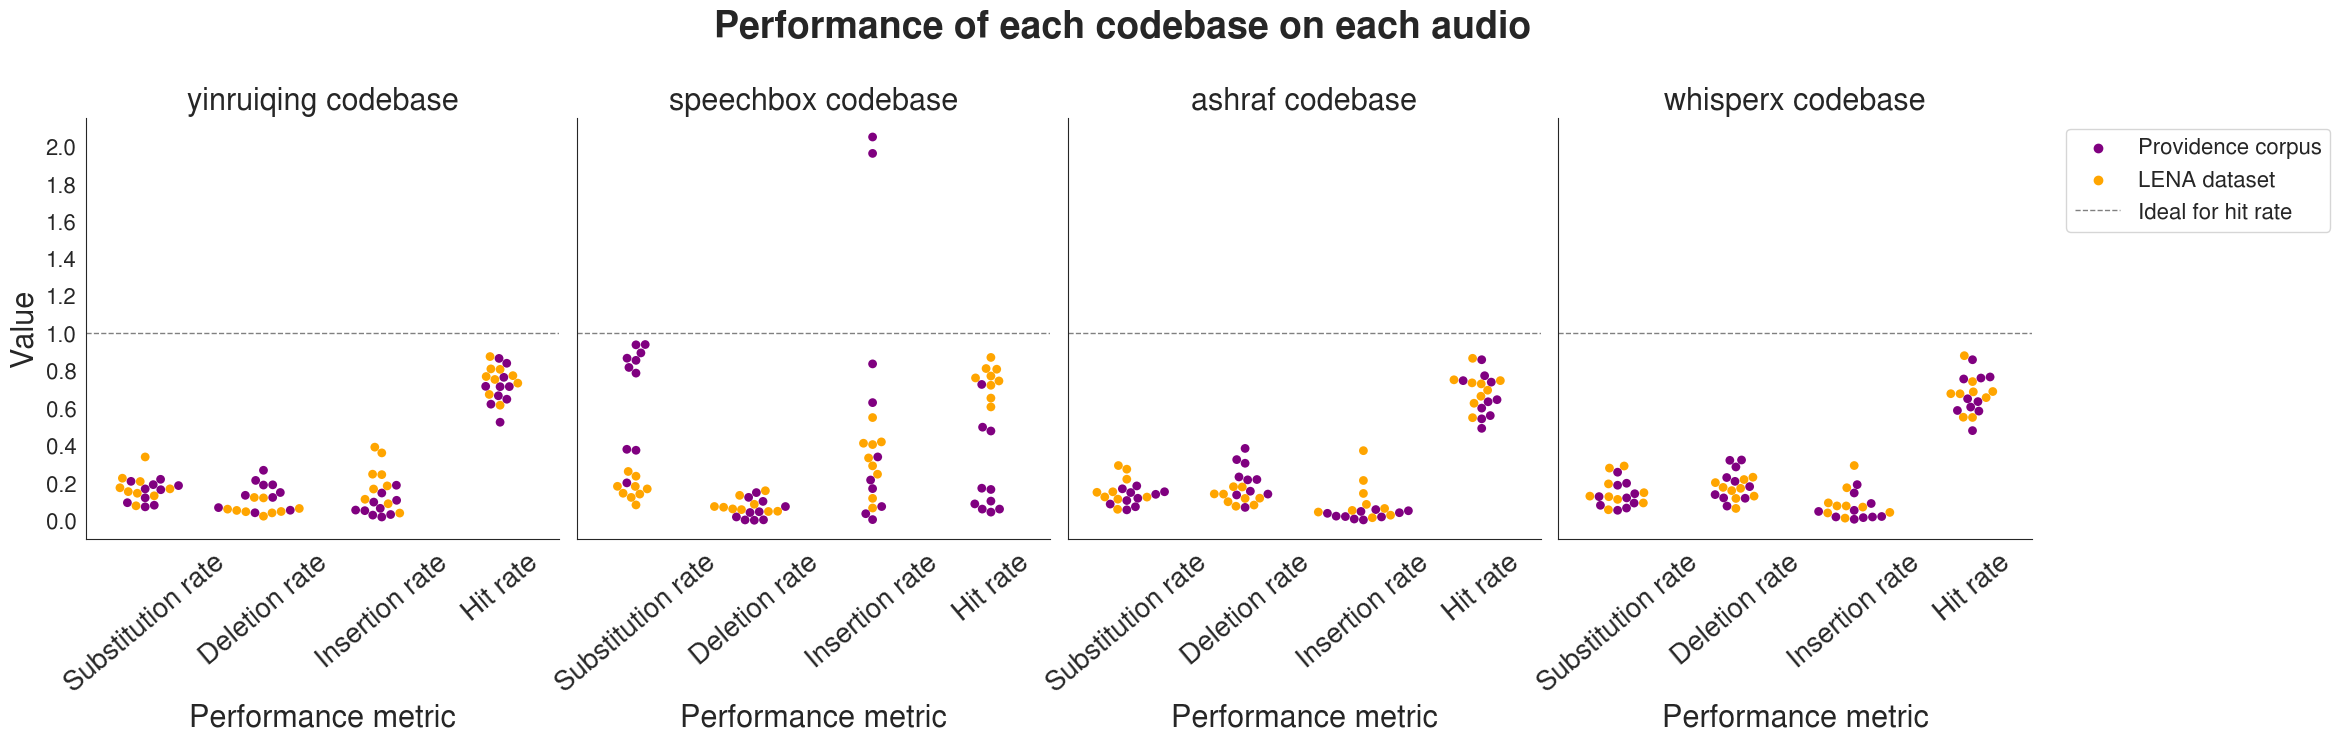

,codebase,audio,performance metric,value,source,codebase_name
0,3,Lily_030725_first5.wav,substitution_rate,0.168254,Providence corpus,ashraf
1,3,34_KS_Recording4-LR_2165-2465_CT.wav,substitution_rate,0.273171,LENA dataset,ashraf
2,3,Ethan_021005_first5.wav,substitution_rate,0.183673,Providence corpus,ashraf
3,3,85_NA_Recording1-LR_2244-2544_CT.wav,substitution_rate,0.292683,LENA dataset,ashraf
4,3,William_030011_first5.wav,substitution_rate,0.138710,Providence corpus,ashraf
...,...,...,...,...,...,...
299,1,Naima_020720_first5.wav,hit_rate,0.715139,Providence corpus,yinruiqing
300,1,Alex_010526_first5.wav,hit_rate,0.840000,Providence corpus,yinruiqing
301,1,40_JC_Recording1-LR_2662-2962_CT.wav,hit_rate,0.875878,LENA dataset,yinruiqing
302,1,Violet_030119_first5.wav,hit_rate,0.716522,Providence corpus,yinruiqing


In [115]:
createSwarmErrorRatePlots()

### Speaker detection (diarization) analysis

In [9]:
def howManySpeakers(filepath,goldpath):
    modelcsv = pd.read_csv(filepath)
    goldcsv = pd.read_csv(goldpath)
    unique_speakers_model =  modelcsv['speaker'].nunique()
    try:
        unique_speakers_gold =  goldcsv['speaker_role'].nunique()
    except:
        unique_speakers_gold =  goldcsv['speaker'].nunique()

    modelcsv['token_length'] = (modelcsv['text'].astype(str)).str.split().apply(len)
    missing_speaker_utterances = modelcsv[modelcsv['speaker'].isnull()]['token_length']
    total_utterances = modelcsv['token_length']
    prop_lost_tokens = missing_speaker_utterances.sum()/total_utterances.sum()

    return unique_speakers_model, unique_speakers_gold, prop_lost_tokens

In [30]:
def speakerCountsPlots(special_dir="",latest_timestamp=""):

    latest_timestamp, list_of_filepaths, list_of_files, list_of_audio, list_of_gold_transcripts = util.prepareMyData(latest_timestamp)
    N = len(list_of_filepaths)
    modelvalues = []
    goldvalues = []
    cb_df=[]
    for i in range(N):
        model,gold, prop_lost_tokens = howManySpeakers(list_of_filepaths[i], list_of_gold_transcripts[i])
        modelvalues.append(model)
        goldvalues.append(gold)
        cb_df.append(1+codebasenameoptions.index(os.path.basename(os.path.split(list_of_filepaths[i])[0])))

    speaker_counts_df = pd.DataFrame(list(zip(list_of_audio,cb_df,modelvalues,goldvalues)), columns =['audio', 'codebase','cb_speakers', 'gold_speakers']) 
    speaker_counts_df['residual'] = -1*speaker_counts_df['cb_speakers'] + speaker_counts_df['gold_speakers']


    speaker_counts_df['source'] = np.where(speaker_counts_df['audio'].str[-5:]=="5.wav","Providence corpus","LENA dataset")
    speaker_counts_df['codebase_name'] = speaker_counts_df['codebase'].map(codebase_mapping_dict)
    plt.figure()
    g = sns.catplot(data=speaker_counts_df ,y='residual', col="codebase_name",col_order = codebasenameoptions, hue='source',aspect=0.5,height=4,kind ='swarm',palette=['purple','orange'] ,  s=55,legend_out=False)
    for ax in g.axes.flat:
        ax.set_yticks(np.arange(-4,6,1))

    g.fig.suptitle('Residuals of # of distinct speakers in audio', **hfont,fontsize=16,weight='bold')
    g.set_ylabels('Residual (= True value - Model value)', fontdict={'fontfamily': 'Nimbus Sans','fontsize':12})
    g.set_titles("{col_name} codebase", fontdict={'fontfamily': 'Nimbus Sans', 'fontsize':14})
    plt.ylabel('Residual (= True value - Model value)', **hfont)
    plt.subplots_adjust(top=0.8)
    speakerCountsPlots
    sns.move_legend(g, "upper right")
    g._legend.set_title("Dataset",prop={'family': 'Nimbus Sans'})
    for text in g._legend.get_texts():
        text.set_fontfamily('Nimbus Sans')   
    for ax in g.axes.flat:
        ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, label='Ideal for residual')
    plt.legend(prop={'family': 'Nimbus Sans'},bbox_to_anchor=(1.05, 1),loc='upper left')
    speaker_counts_df.to_csv('speaker_counts_'+latest_timestamp+'.csv', index=False)
    name_of_plot = 'speaker_counts_'+latest_timestamp+'.pdf'
    g._legend.remove()
    if special_dir!="":
            name_of_plot = os.path.join(special_dir,name_of_plot )

    plt.savefig(name_of_plot , format='pdf',bbox_inches='tight')
    plt.show()
    return speaker_counts_df

/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

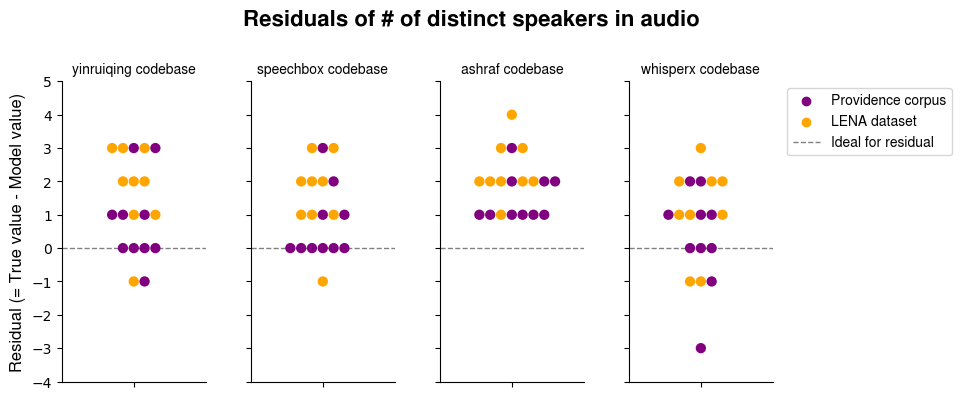

,audio,codebase,cb_speakers,gold_speakers,residual,source,codebase_name
0,Lily_030725_first5.wav,3,2,4,2,Providence corpus,ashraf
1,34_KS_Recording4-LR_2165-2465_CT.wav,3,1,3,2,LENA dataset,ashraf
2,Ethan_021005_first5.wav,3,1,2,1,Providence corpus,ashraf
3,85_NA_Recording1-LR_2244-2544_CT.wav,3,1,4,3,LENA dataset,ashraf
4,William_030011_first5.wav,3,1,3,2,Providence corpus,ashraf
...,...,...,...,...,...,...,...
71,Naima_020720_first5.wav,1,1,2,1,Providence corpus,yinruiqing
72,Alex_010526_first5.wav,1,1,2,1,Providence corpus,yinruiqing
73,40_JC_Recording1-LR_2662-2962_CT.wav,1,4,3,-1,LENA dataset,yinruiqing
74,Violet_030119_first5.wav,1,1,4,3,Providence corpus,yinruiqing


In [47]:
speakerCountsPlots()

In [29]:
def speakerCountsViolinPlots(special_dir="",latest_timestamp=""):

    latest_timestamp, list_of_filepaths, list_of_files, list_of_audio, list_of_gold_transcripts = util.prepareMyData(latest_timestamp)

    N = len(list_of_filepaths)
    modelvalues = []
    goldvalues = []
    cb_df=[]

    for i in range(N):
        model,gold, prop_lost_tokens = howManySpeakers(list_of_filepaths[i], list_of_gold_transcripts[i])
        modelvalues.append(model)
        goldvalues.append(gold)
        cb_df.append(1+codebasenameoptions.index(os.path.basename(os.path.split(list_of_filepaths[i])[0])))

    speaker_counts_df = pd.DataFrame(list(zip(list_of_audio,cb_df,modelvalues,goldvalues)), columns =['audio', 'codebase','cb_speakers', 'gold_speakers']) 
    speaker_counts_df['residual'] =  speaker_counts_df['gold_speakers'] - speaker_counts_df['cb_speakers']


    speaker_counts_df['source'] = np.where(speaker_counts_df['audio'].str[-5:]=="5.wav","Providence corpus","LENA dataset")
    speaker_counts_df['codebase_name'] = speaker_counts_df['codebase'].map(codebase_mapping_dict)
    plt.figure(figsize=(20,10))    
    plt.subplots_adjust(top=0.8)
    
    sns.catplot(data=speaker_counts_df, x="codebase_name", y="residual", kind="violin",   inner=None, order = codebasenameoptions,color='white',height=5,aspect=1.5)
    ax = sns.swarmplot(data=speaker_counts_df, x="codebase_name",y="residual", size=8,hue='source',order=codebasenameoptions,palette=['purple','orange'],legend='full')
     
    plt.title("Residuals of # of distinct speakers in audio",**hfont,fontsize=14,fontweight='bold')
    plt.xticks(codebasenameoptions, [cb + " codebase" for cb in codebasenameoptions],**hfont,fontsize=12)

    plt.yticks(np.arange(-5,6,1))
    plt.xlabel("Name of codebase (in order)",**hfont,fontsize=12)
    plt.ylabel("Residual (= True value - Model value)",**hfont,fontsize=12)
    
    L = ax.legend(title='Dataset',loc='lower left')
    plt.setp(L.texts, family='Nimbus Sans')
    plt.setp(L.get_title(), family='Nimbus Sans')

    plt.axhline(y=0, color='gray', linestyle='--',linewidth=1, label='Ideal for residuals')
    plt.text(x=1.5, y=-4, s="Model overcounts in this region", fontsize=12,  color='black', **hfont,fontstyle='italic')
    plt.text(x=0.2, y=4.5, s="Model undercounts in this region", fontsize=12,  color='black', **hfont,fontstyle='italic')
    plt.legend(prop={'family': 'Nimbus Sans'},bbox_to_anchor=(1.05, 1),loc='upper left')
    speaker_counts_df.to_csv('speaker_counts_'+latest_timestamp+'_violin.csv', index=False)
    name_of_plot='speaker_counts_'+latest_timestamp+'_violin.pdf'
    if special_dir!="":
            name_of_plot = os.path.join(special_dir,name_of_plot )
    plt.savefig(name_of_plot, format='pdf',bbox_inches='tight')
    plt.show()
    return speaker_counts_df


/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 2000x1000 with 0 Axes>

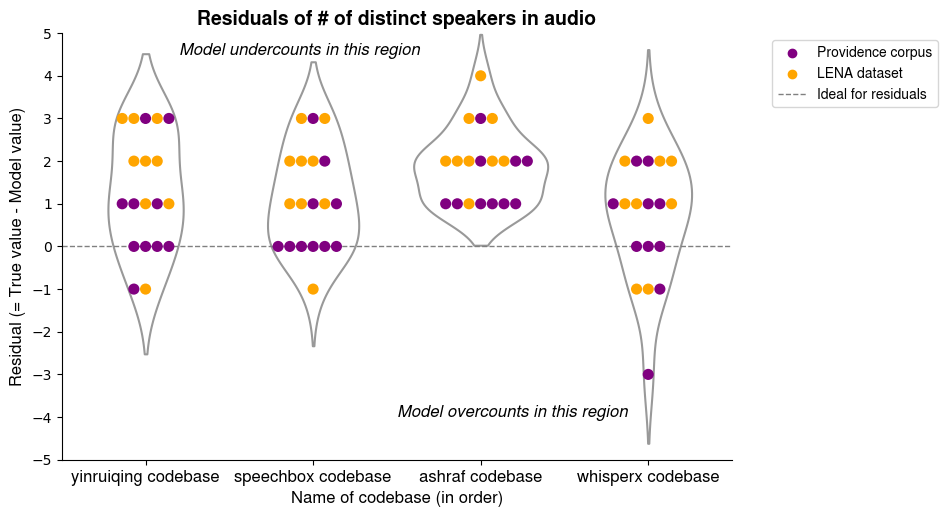

,audio,codebase,cb_speakers,gold_speakers,residual,source,codebase_name
0,Lily_030725_first5.wav,3,2,4,2,Providence corpus,ashraf
1,34_KS_Recording4-LR_2165-2465_CT.wav,3,1,3,2,LENA dataset,ashraf
2,Ethan_021005_first5.wav,3,1,2,1,Providence corpus,ashraf
3,85_NA_Recording1-LR_2244-2544_CT.wav,3,1,4,3,LENA dataset,ashraf
4,William_030011_first5.wav,3,1,3,2,Providence corpus,ashraf
...,...,...,...,...,...,...,...
71,Naima_020720_first5.wav,1,1,2,1,Providence corpus,yinruiqing
72,Alex_010526_first5.wav,1,1,2,1,Providence corpus,yinruiqing
73,40_JC_Recording1-LR_2662-2962_CT.wav,1,4,3,-1,LENA dataset,yinruiqing
74,Violet_030119_first5.wav,1,1,4,3,Providence corpus,yinruiqing


In [100]:
speakerCountsViolinPlots()

In [28]:
def speakerMissingCountsPlots(special_dir="",latest_timestamp=""):

    latest_timestamp, list_of_filepaths, list_of_files, list_of_audio, list_of_gold_transcripts = util.prepareMyData(latest_timestamp)

    N = len(list_of_filepaths)
    modelvalues = []
    goldvalues = []
    propvalues=[]
    cb_df=[]

    for i in range(N):
        model,gold, prop_lost_tokens = howManySpeakers(list_of_filepaths[i], list_of_gold_transcripts[i])
        modelvalues.append(model)
        goldvalues.append(gold)
        propvalues.append(prop_lost_tokens)
        cb_df.append(1+codebasenameoptions.index(os.path.basename(os.path.split(list_of_filepaths[i])[0])))

    speaker_counts_df = pd.DataFrame(list(zip(list_of_audio,cb_df,modelvalues,goldvalues,propvalues)), columns =['audio', 'codebase','cb_speakers', 'gold_speakers','prop_missing']) 
     

    speaker_counts_df['source'] = np.where(speaker_counts_df['audio'].str[-5:]=="5.wav","Providence corpus","LENA dataset")
    speaker_counts_df['codebase_name'] = speaker_counts_df['codebase'].map(codebase_mapping_dict)
    plt.figure(figsize=(20,10))    
    plt.subplots_adjust(top=0.8)

    g=sns.catplot(data=speaker_counts_df, x="codebase_name", y="prop_missing", kind="swarm",size=4.3 ,hue='source',order = codebasenameoptions,height=5,aspect=1.5,palette=['purple','orange'])
      
    plt.title("Proportion of tokens with no speaker assigned to them",**hfont,fontsize=14,fontweight='bold')
    plt.xticks(codebasenameoptions, [cb + " codebase" for cb in codebasenameoptions],**hfont,fontsize=12)

    plt.yticks(np.arange(0,0.35,0.02))
    plt.xlabel("Name of codebase (in order)",**hfont,fontsize=12)
    plt.ylabel("Proportion (of total tokens)",**hfont,fontsize=12)
    
    g._legend.set_title("Dataset",prop={'family': 'Nimbus Sans'})
    for text in g._legend.get_texts():
        text.set_fontfamily('Nimbus Sans')   
    speaker_counts_df.to_csv('speaker_counts_'+latest_timestamp+'_missing.csv', index=False)
    name_of_plot='speaker_counts_'+latest_timestamp+'_missing.pdf'
    if special_dir!="":
            name_of_plot = os.path.join(special_dir,name_of_plot )
    plt.savefig(name_of_plot, format='pdf',bbox_inches='tight')
    plt.show()
    return speaker_counts_df


/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 2000x1000 with 0 Axes>

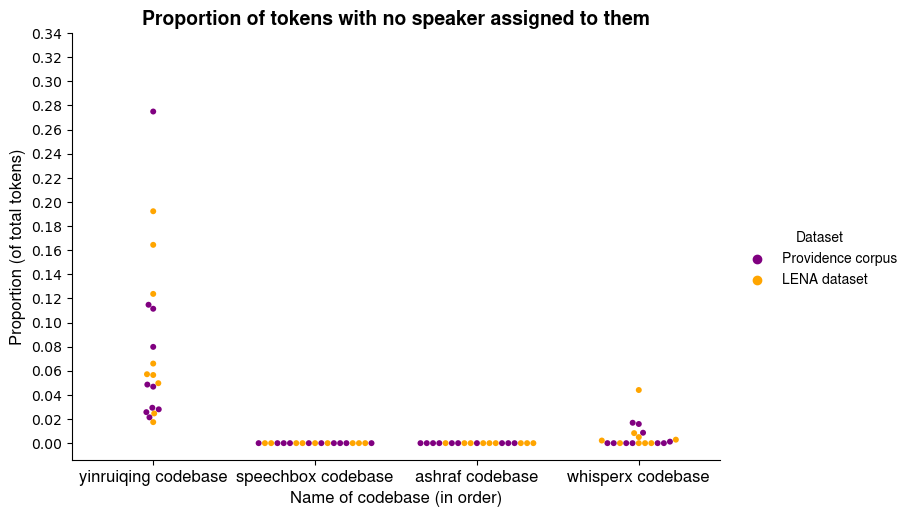

,audio,codebase,cb_speakers,gold_speakers,prop_missing,source,codebase_name
0,Lily_030725_first5.wav,3,2,4,0.000000,Providence corpus,ashraf
1,34_KS_Recording4-LR_2165-2465_CT.wav,3,1,3,0.000000,LENA dataset,ashraf
2,Ethan_021005_first5.wav,3,1,2,0.000000,Providence corpus,ashraf
3,85_NA_Recording1-LR_2244-2544_CT.wav,3,1,4,0.000000,LENA dataset,ashraf
4,William_030011_first5.wav,3,1,3,0.000000,Providence corpus,ashraf
...,...,...,...,...,...,...,...
71,Naima_020720_first5.wav,1,1,2,0.046838,Providence corpus,yinruiqing
72,Alex_010526_first5.wav,1,1,2,0.275000,Providence corpus,yinruiqing
73,40_JC_Recording1-LR_2662-2962_CT.wav,1,4,3,0.017422,LENA dataset,yinruiqing
74,Violet_030119_first5.wav,1,1,4,0.079832,Providence corpus,yinruiqing


In [12]:
speakerMissingCountsPlots()

### Saving all plots to a folder specified by the user

In [41]:
def saveMyPlots(foldername, latest_timestamp = ""):
        folderlink = os.path.join('/om/user/arjunp',foldername)
        if not os.path.exists(folderlink):
            os.makedirs(folderlink)
#removed 'word-counts-logdensity'
        plots_to_make = ['missing-speakers','speaker-counts-violin','speaker-counts-swarm','word-counts-rmse','wer','audio-errors','error-rate-swarm','error-rate-facet'] 
        for plot in plots_to_make:
            a = createLatestPlots(plot,folderlink,latest_timestamp)
    

In [19]:
%%time
saveMyPlots("beam8", '1725913741')
saveMyPlots("beam7", '1725913112')
saveMyPlots("beam6", '1725912506')
saveMyPlots("beam5", '1725911920')
saveMyPlots("beam4", '1725911379')
saveMyPlots("beam3", '1725910870')
saveMyPlots("beam2", '1725910389')

ValueError: Length mismatch: Expected axis has 1 elements, new values have 4 elements

<Figure size 1000x800 with 0 Axes>

In [27]:
def speakerCountsScatter(special_dir="",latest_timestamp=""):
        latest_timestamp, list_of_filepaths, list_of_files, list_of_audio, list_of_gold_transcripts = util.prepareMyData(latest_timestamp)

        N = len(list_of_filepaths)
        modelvalues = []
        goldvalues = []
        cb_df=[]

        for i in range(N):
                model,gold, prop_lost_tokens = howManySpeakers(list_of_filepaths[i], list_of_gold_transcripts[i])
                modelvalues.append(model)
                goldvalues.append(gold)
                cb_df.append(1+codebasenameoptions.index(os.path.basename(os.path.split(list_of_filepaths[i])[0])))

        speaker_counts_df = pd.DataFrame(list(zip(list_of_audio,cb_df,modelvalues,goldvalues)), columns =['audio', 'codebase','cb_speakers', 'gold_speakers']) 
        speaker_counts_df['residual'] =  speaker_counts_df['gold_speakers'] - speaker_counts_df['cb_speakers']

        speaker_counts_df['source'] = np.where(speaker_counts_df['audio'].str[-5:]=="5.wav","Providence corpus","LENA dataset")
        speaker_counts_df['codebase_name'] = speaker_counts_df['codebase'].map(codebase_mapping_dict)
        plt.figure( )    
        
        g = sns.FacetGrid(speaker_counts_df, col="codebase_name",    margin_titles=True, height=6, aspect=1,hue='source',palette=['purple','orange'],legend_out=True)
        g.map(sns.scatterplot,   'gold_speakers',   'cb_speakers',s=75, alpha=0.5)
        g.map(sns.lineplot,'gold_speakers',  'gold_speakers', color='gray', linestyle ='-',label='Ideal case')
        g.map(sns.lineplot,'cb_speakers',  'cb_speakers', color='gray', linestyle ='-')
         

        plt.subplots_adjust(top=0.9)

        plt.yticks(np.arange(0,6,1))
        plt.xticks(np.arange(0,6,1))
        
        g.fig.suptitle('No. of distinct speakers in audio: model v/s true value', **hfont,fontsize=16,weight='bold')
        g.set_xlabels("No. of speakers in ground truth", fontdict={'fontfamily': 'Nimbus Sans','fontsize':12})
        g.set_ylabels("No. of speakers identified by model", fontdict={'fontfamily': 'Nimbus Sans','fontsize':12})

        
        g.set_titles(col_template="{col_name} codebase", row_template = "{row_name}")#fontdict={'fontfamily': 'Nimbus Sans', 'fontsize':14})

        plt.legend(prop={'family': 'Nimbus Sans'},bbox_to_anchor=(1.05, 1),loc='upper left')
        
        for ax in g.axes.flat:
                ax.set_yticks(np.arange(1,7,1))
                ax.set_xticks(np.arange(1,7,1)) 
                
        speaker_counts_df.to_csv('speaker_counts_'+latest_timestamp+'_raw.csv', index=False)
        name_of_plot='speaker_counts_'+latest_timestamp+'_raw.pdf'
        if special_dir!="":
                name_of_plot = os.path.join(special_dir,name_of_plot )
        plt.savefig(name_of_plot, format='pdf',bbox_inches='tight')
        plt.show()
         

/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

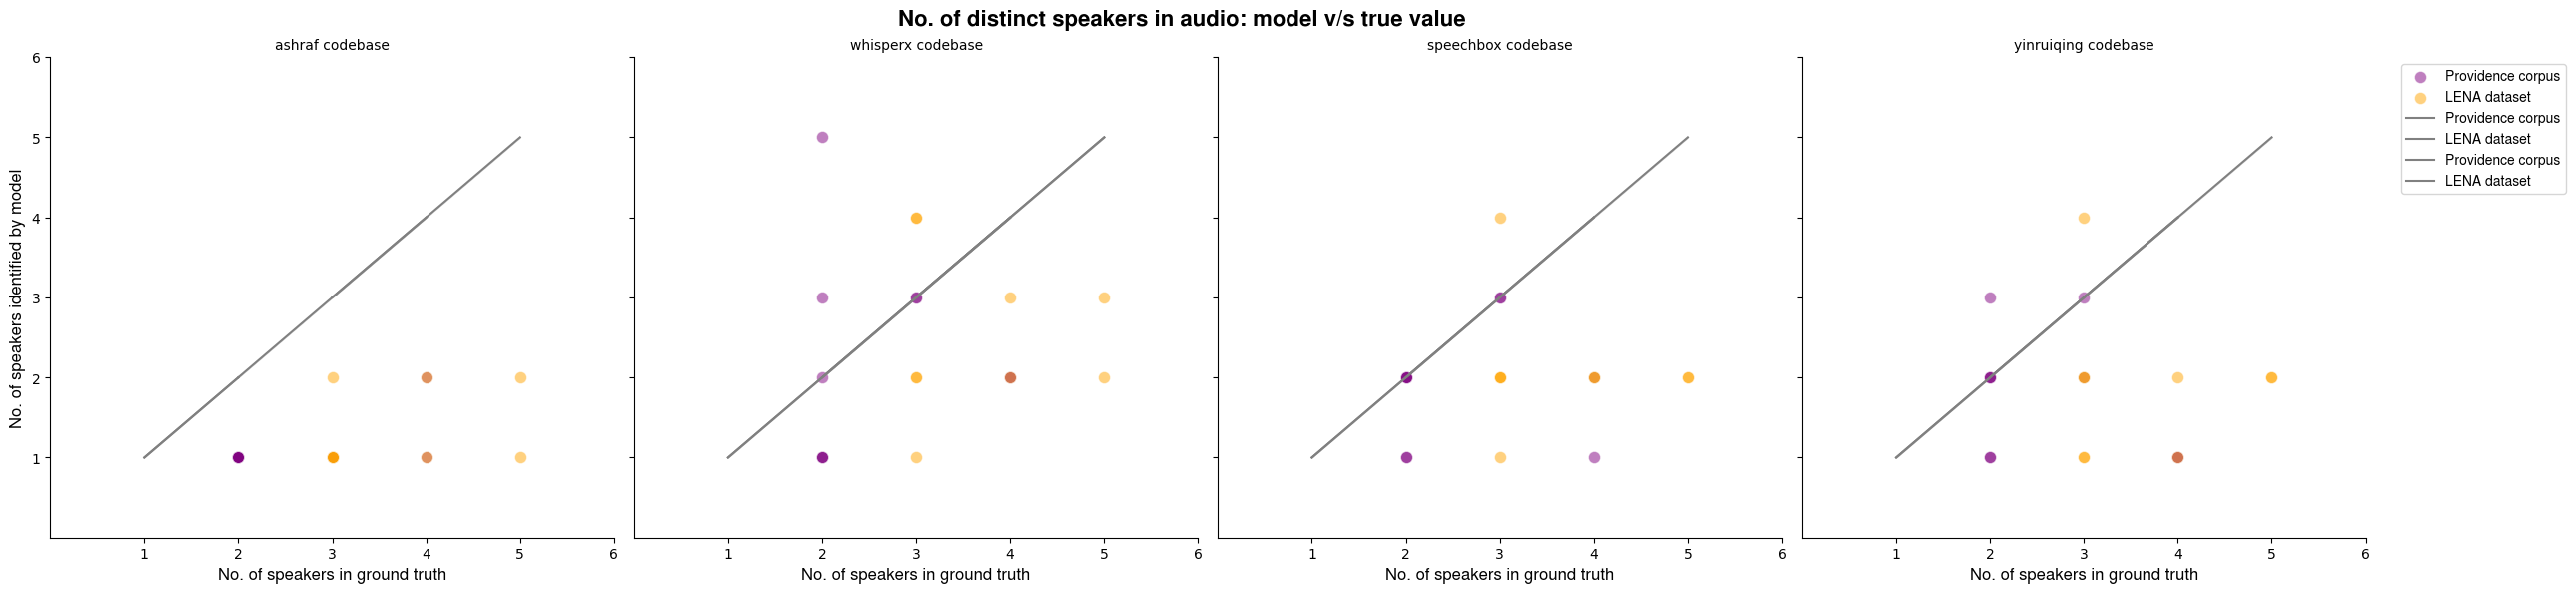

In [207]:
speakerCountsScatter()

In [26]:
def draw_heatmap(data, **kwargs):
        full_row_range = [5,4,3,2,1]  # Complete row indices
        full_column_range = [ 2, 3, 4,5]  # Complete column indices
        pivoted_df = data.pivot(index =  "cb_speakers" , columns = "gold_speakers", values="audio").fillna(0)
        df = pivoted_df.reindex(index=full_row_range, columns=full_column_range, fill_value=0)
        sns.heatmap(df, **kwargs)
 
    
def speakerCountsHeat(special_dir="",latest_timestamp=""):
        latest_timestamp, list_of_filepaths, list_of_files, list_of_audio, list_of_gold_transcripts = util.prepareMyData(latest_timestamp)

        N = len(list_of_filepaths)
        modelvalues = []
        goldvalues = []
        cb_df=[]

        for i in range(N):
                model,gold, prop_lost_tokens = howManySpeakers(list_of_filepaths[i], list_of_gold_transcripts[i])
                modelvalues.append(model)
                goldvalues.append(gold)
                cb_df.append(1+codebasenameoptions.index(os.path.basename(os.path.split(list_of_filepaths[i])[0])))

        speaker_counts_df = pd.DataFrame(list(zip(list_of_audio,cb_df,modelvalues,goldvalues)), columns =['audio', 'codebase','cb_speakers', 'gold_speakers']) 
        speaker_counts_df['residual'] =  speaker_counts_df['gold_speakers'] - speaker_counts_df['cb_speakers']

        speaker_counts_df['source'] = np.where(speaker_counts_df['audio'].str[-5:]=="5.wav","Providence corpus","LENA dataset")
        speaker_counts_df['codebase_name'] = speaker_counts_df['codebase'].map(codebase_mapping_dict)
        
        speaker_counts_df = speaker_counts_df.groupby(['codebase_name','source','gold_speakers','cb_speakers']).agg('count').reset_index()
        
        plt.figure() 
        g = sns.FacetGrid(speaker_counts_df, col="codebase_name", row = 'source',   margin_titles=True, height=6, aspect=1,legend_out=True,col_order=codebasenameoptions)
        
        #pivoted_df = speaker_counts_df.pivot(index =  "cb_speakers" , columns = "gold_speakers", values="audio")
        
        #g.map(sns.heatmap(data=speaker_counts_df, cmap="crest",annot=True))
        g.map_dataframe(draw_heatmap, cmap="crest",annot=True,cbar=False)  
        g.fig.suptitle('No. of distinct speakers in audio: model v/s true value', **hfont,fontsize=24,weight='bold')
        g.set_xlabels("No. of speakers in ground truth", fontdict={'fontfamily': 'Nimbus Sans','fontsize':20})
        g.set_ylabels("No. of speakers identified by model", fontdict={'fontfamily': 'Nimbus Sans','fontsize':20})
        g.set_titles(col_template="{col_name} codebase", row_template = "{row_name}",**hfont,size=20)#fontdict={'fontfamily': 'Nimbus Sans', 'fontsize':14})
        plt.subplots_adjust(top=0.9)
         
        for ax in g.axes.flat:
                ax.set_yticks(size=16,**hfont)
                ax.set_xticks(size=20) 
        name_of_plot='speaker_counts_'+latest_timestamp+'_heat.pdf'
        if special_dir!="":
                name_of_plot = os.path.join(special_dir,name_of_plot )
        plt.savefig(name_of_plot, format='pdf',bbox_inches='tight')
        plt.show()


       
        return speaker_counts_df
        ''' 
        
 

        

        plt.yticks(np.arange(0,6,1))
        plt.xticks(np.arange(0,6,1))
        

        

        plt.legend(prop={'family': 'Nimbus Sans'},bbox_to_anchor=(1.05, 1),loc='upper left')
        
        for ax in g.axes.flat:
                ax.set_yticks(np.arange(1,7,1))
                ax.set_xticks(np.arange(1,7,1)) 
                
        speaker_counts_df.to_csv('speaker_counts_'+latest_timestamp+'_raw.csv', index=False)
        name_of_plot='speaker_counts_'+latest_timestamp+'_raw.pdf'
        if special_dir!="":
                name_of_plot = os.path.join(special_dir,name_of_plot )
        plt.savefig(name_of_plot, format='pdf',bbox_inches='tight')
        plt.show()'''
         
         

/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


TypeError: Axis.set_ticks() missing 1 required positional argument: 'ticks'

<Figure size 640x480 with 0 Axes>

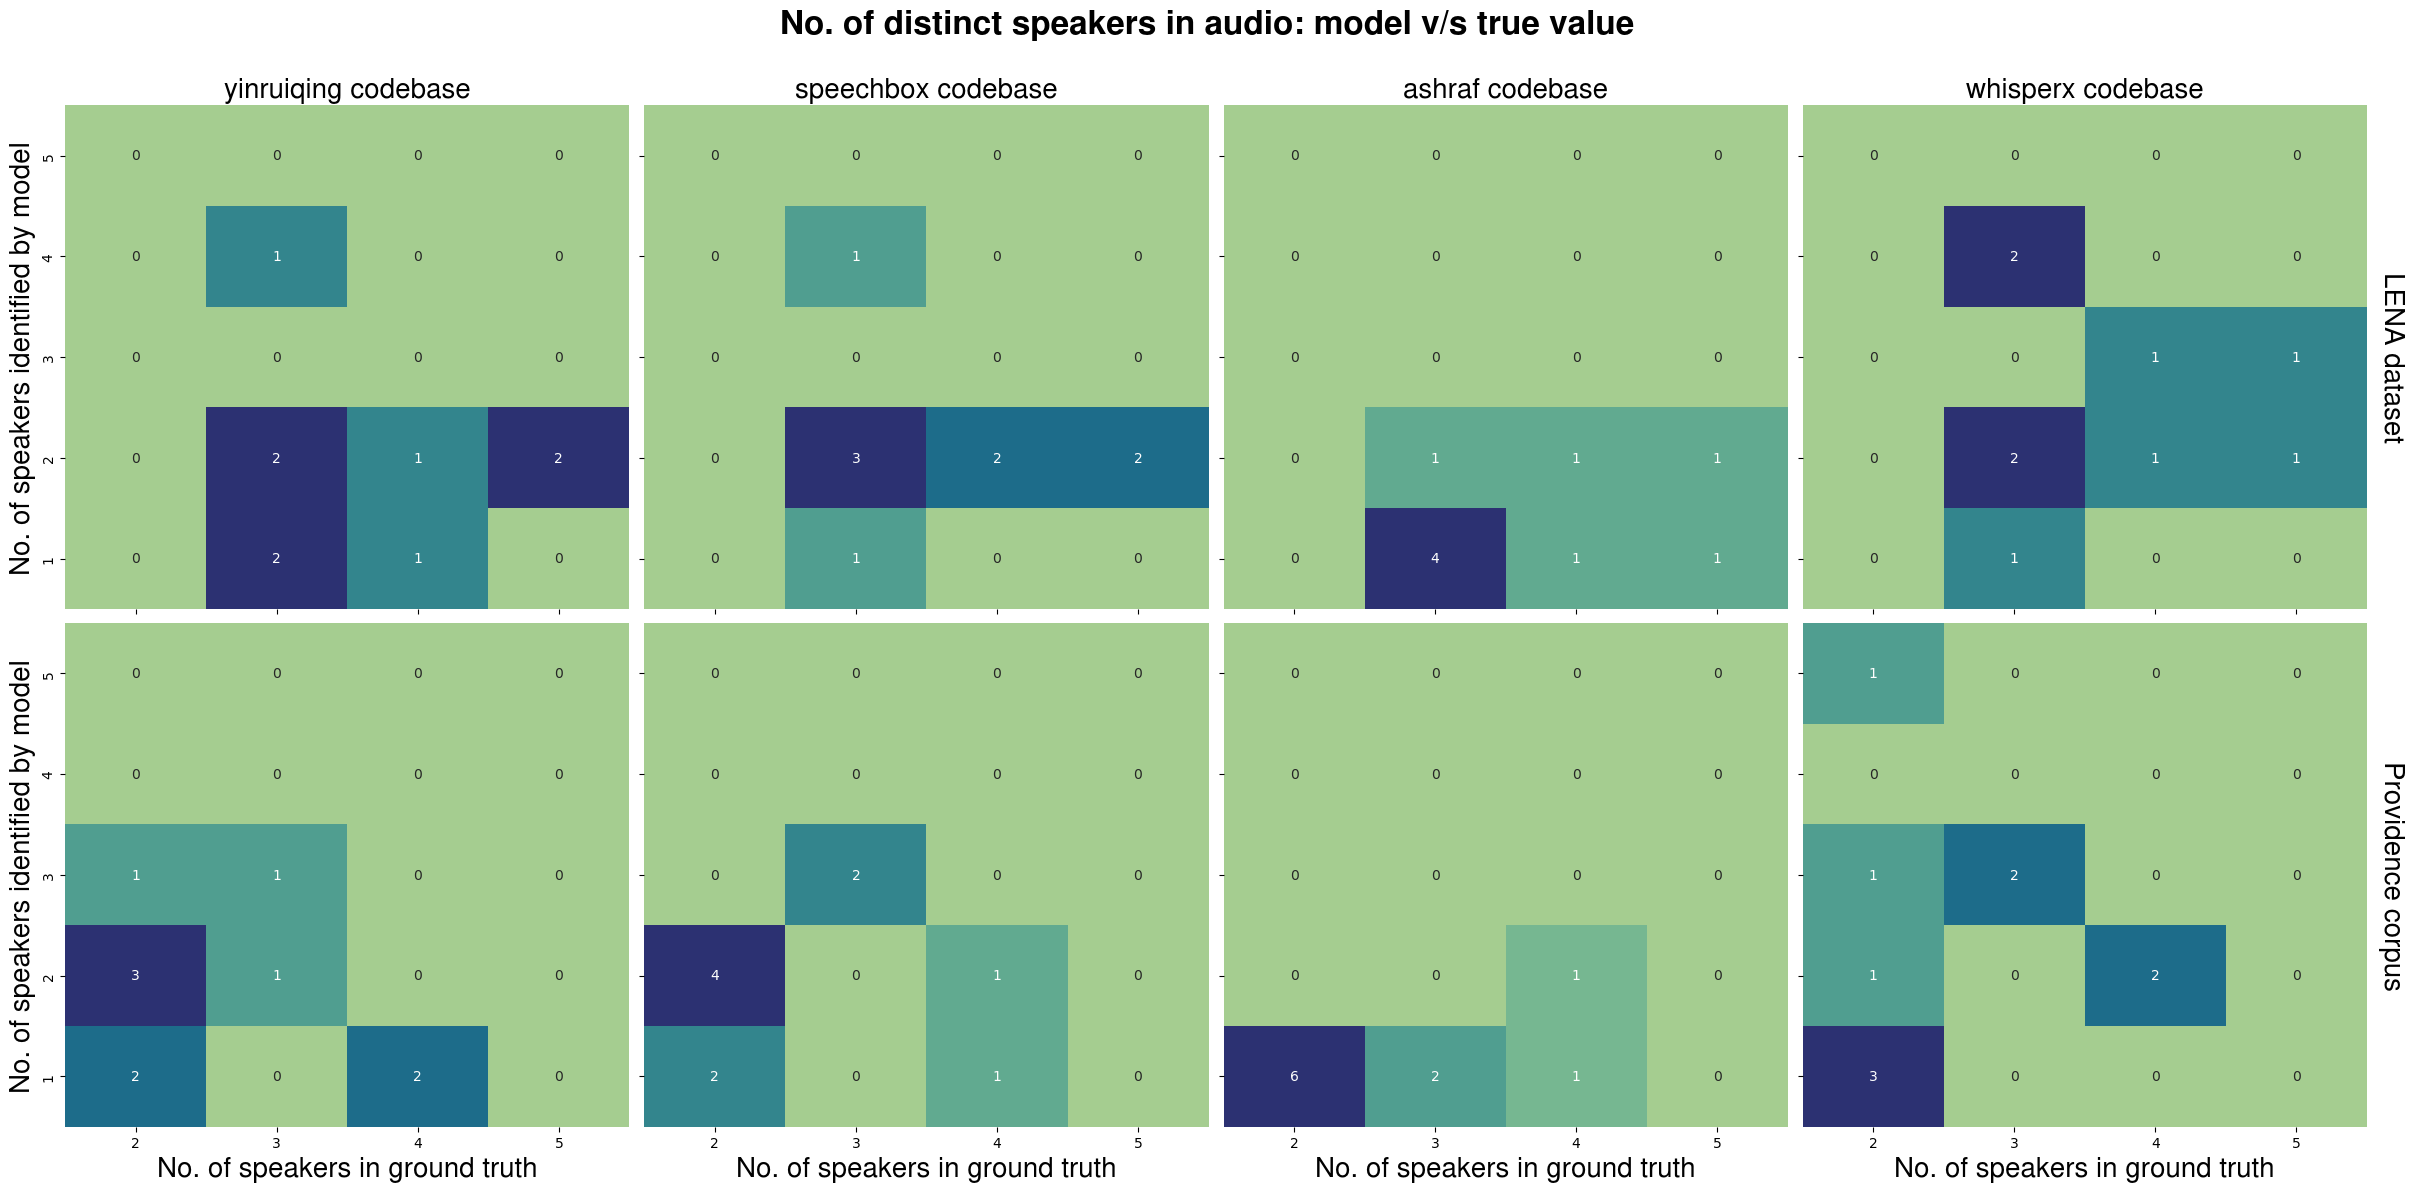

In [83]:
speakerCountsHeat()

In [25]:
def speakerCountsDensity(special_dir="",latest_timestamp=""):
        latest_timestamp, list_of_filepaths, list_of_files, list_of_audio, list_of_gold_transcripts = util.prepareMyData(latest_timestamp)

        N = len(list_of_filepaths)
        modelvalues = []
        goldvalues = []
        cb_df=[]

        for i in range(N):
                model,gold, prop_lost_tokens = howManySpeakers(list_of_filepaths[i], list_of_gold_transcripts[i])
                modelvalues.append(model)
                goldvalues.append(gold)
                cb_df.append(1+codebasenameoptions.index(os.path.basename(os.path.split(list_of_filepaths[i])[0])))

        speaker_counts_df = pd.DataFrame(list(zip(list_of_audio,cb_df,modelvalues,goldvalues)), columns =['audio', 'codebase','cb_speakers', 'gold_speakers']) 
        speaker_counts_df['residual'] =  speaker_counts_df['gold_speakers'] - speaker_counts_df['cb_speakers']

        speaker_counts_df['source'] = np.where(speaker_counts_df['audio'].str[-5:]=="5.wav","Providence corpus","LENA dataset")
        speaker_counts_df['codebase_name'] = speaker_counts_df['codebase'].map(codebase_mapping_dict)
        plt.figure( )    
        
        #g = sns.FacetGrid(speaker_counts_df, col="codebase_name",    margin_titles=True, height=6, aspect=1,hue='source',palette=['purple','orange'],legend_out=True)
        #g.map(sns.scatterplot,   'gold_speakers',   'cb_speakers',s=55, alpha=0.7)
        #g.map(sns.lineplot,'gold_speakers',  'gold_speakers', color='gray', linestyle ='-',label='Ideal case')
        #g.map(sns.lineplot,'cb_speakers',  'cb_speakers', color='gray', linestyle ='-')
        df_for_facet  = (speaker_counts_df.groupby(['codebase','source','gold_speakers','cb_speakers']).agg(counts=('audio','count'))).reset_index()

        unrolled_df = df_for_facet.loc[df_for_facet.index.repeat(df_for_facet['counts'])].reset_index(drop=True)
        unrolled_df['codebase_name'] = unrolled_df['codebase'].map(codebase_mapping_dict)
        #g = sns.FacetGrid(speaker_counts_df, col="codebase_name",    margin_titles=True, height=6, aspect=1,hue='source',palette=['purple','orange'],legend_out=True)
        g = sns.FacetGrid(unrolled_df, col="codebase_name", row="source", margin_titles=True, height=12, aspect=1,col_order=codebasenameoptions)

        g.map(sns.kdeplot,  'gold_speakers',   'cb_speakers',  fill=True,thresh=0, levels=30, cmap="mako",bw_method=1)


        plt.subplots_adjust(top=0.9)

        plt.yticks(np.arange(0,6,1))
        plt.xticks(np.arange(0,6,1))
        
        g.fig.suptitle('No. of distinct speakers in audio: model v/s true value', **hfont,fontsize=16,weight='bold')
        g.set_xlabels("No. of speakers in ground truth", fontdict={'fontfamily': 'Nimbus Sans','fontsize':12})
        g.set_ylabels("No. of speakers identified by model", fontdict={'fontfamily': 'Nimbus Sans','fontsize':12})

        
        g.set_titles(col_template="{col_name} codebase", row_template = "{row_name}")#fontdict={'fontfamily': 'Nimbus Sans', 'fontsize':14})

        plt.legend(prop={'family': 'Nimbus Sans'},bbox_to_anchor=(1.05, 1),loc='upper left')
        
        for ax in g.axes.flat:
                ax.set_yticks(np.arange(1,7,1))
                ax.set_xticks(np.arange(1,7,1)) 
                
        speaker_counts_df.to_csv('speaker_counts_'+latest_timestamp+'_raw.csv', index=False)
        name_of_plot='speaker_counts_'+latest_timestamp+'_raw.pdf'
        if special_dir!="":
                name_of_plot = os.path.join(special_dir,name_of_plot )
        plt.savefig(name_of_plot, format='pdf',bbox_inches='tight')
        plt.show()
        return unrolled_df


/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

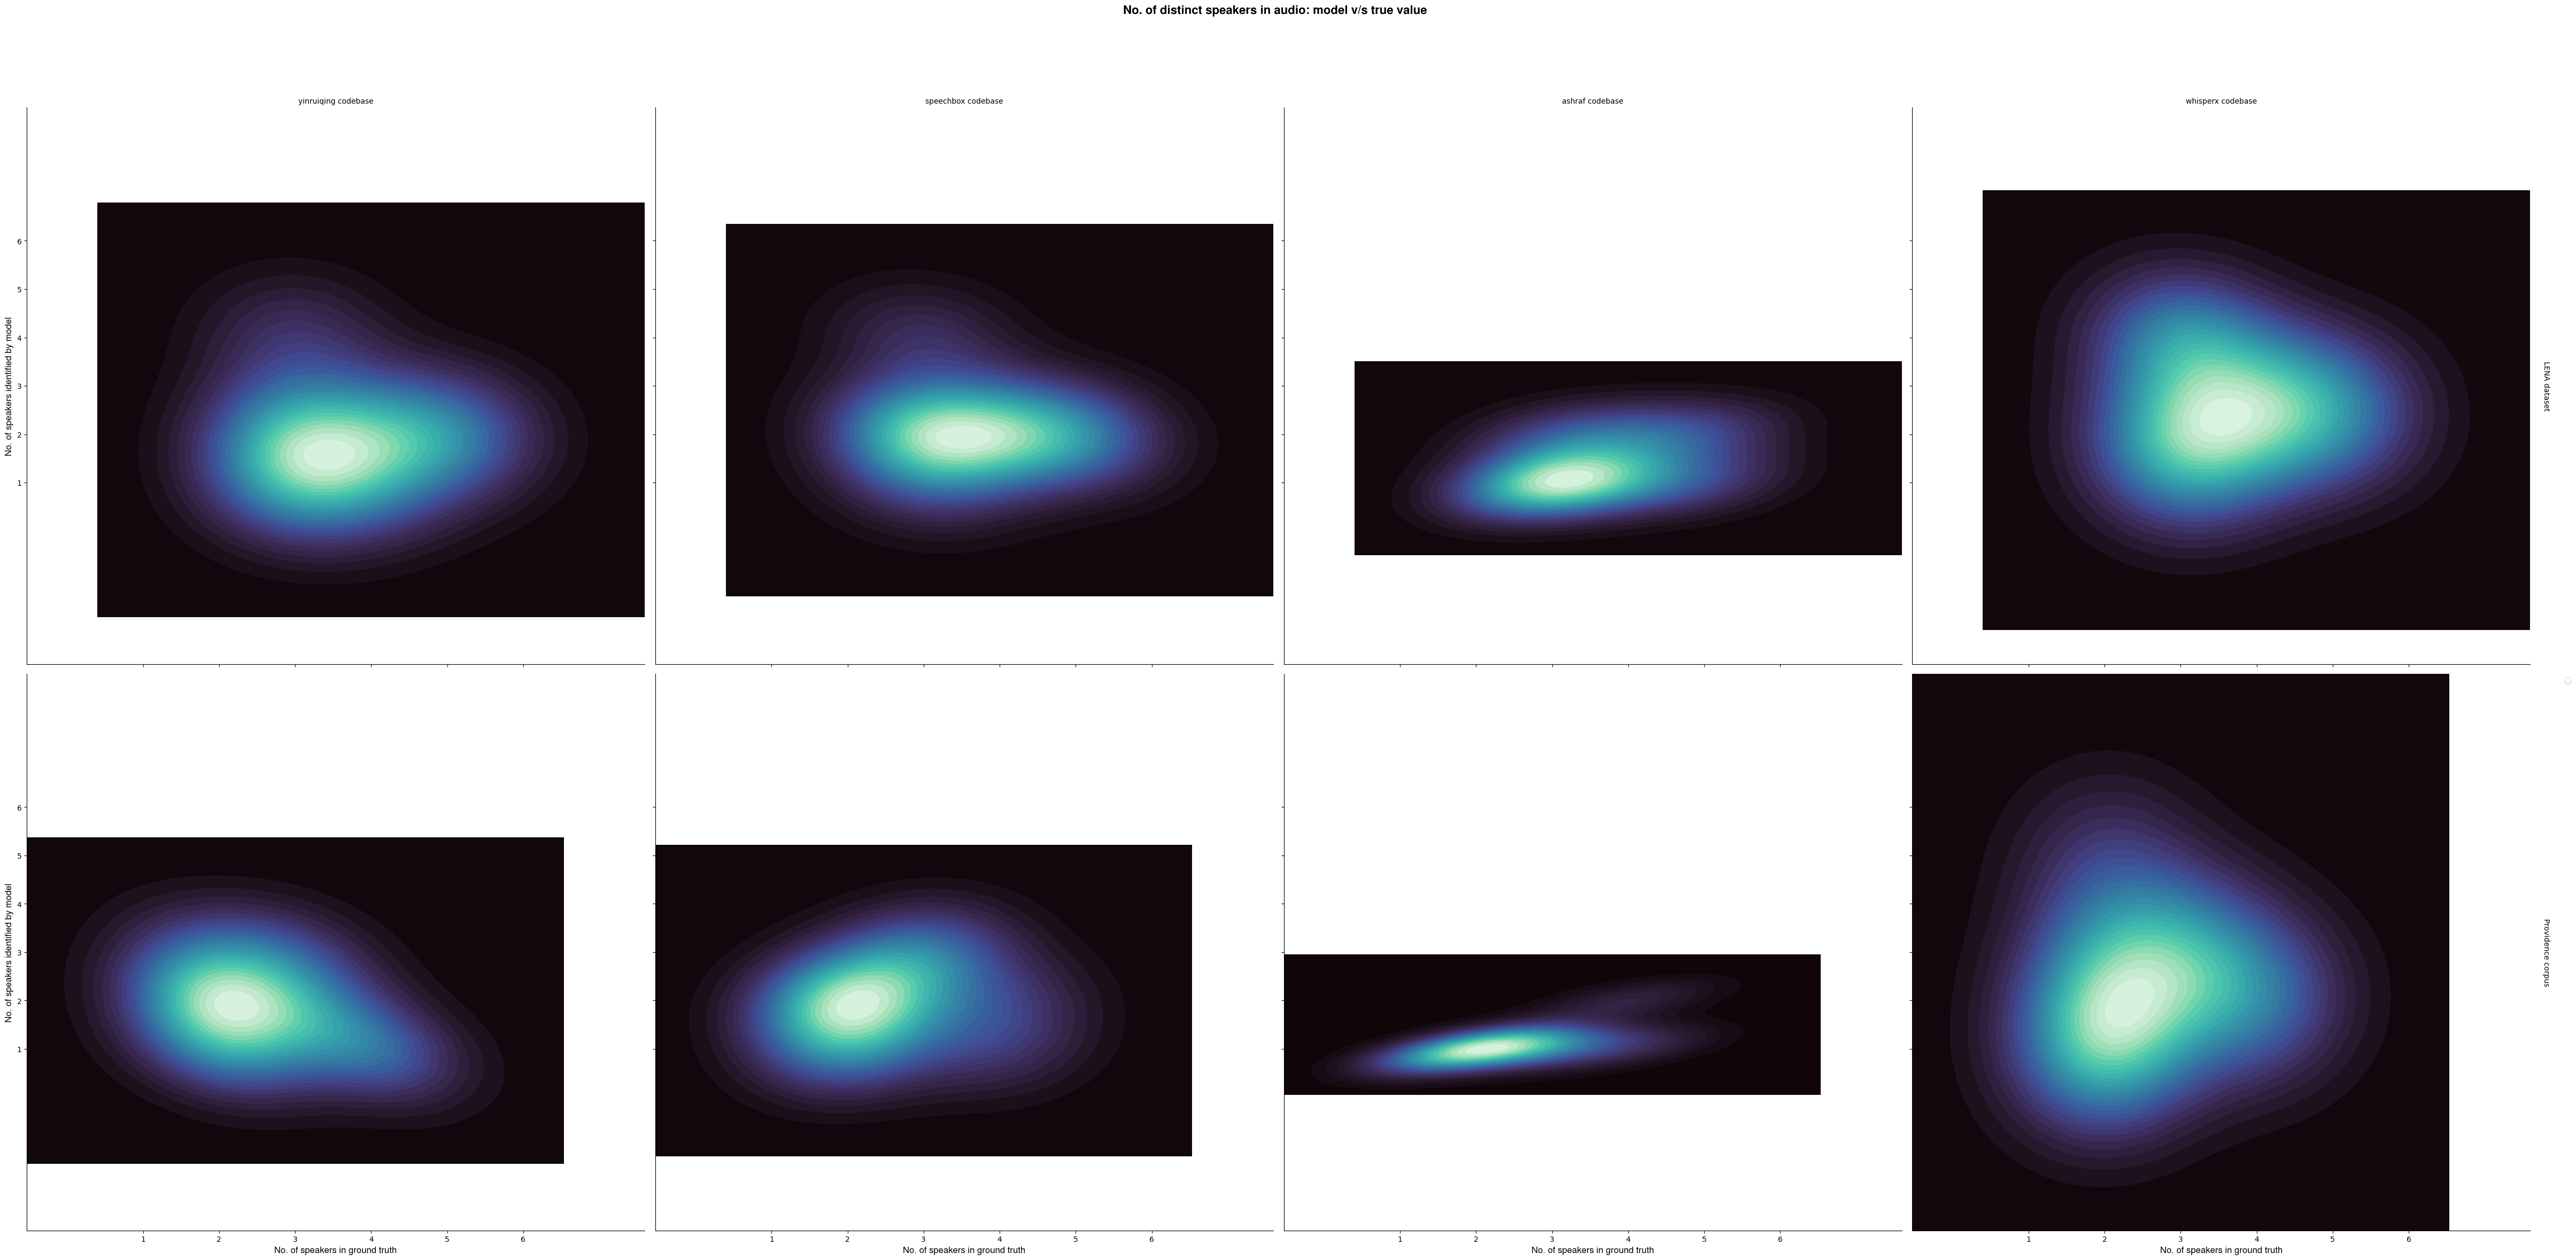

In [201]:
s = speakerCountsScatter()

Example of word alignment by Levenshtein distance  

In [223]:
referencedf = pd.read_csv('/om/user/arjunp/goldTranscripts/34_KS_Recording4-LR_2165-2465_CT-IC.csv')
hypodf = pd.read_csv('/om/user/arjunp/pipelineOutput/1723004242/ashraf/34_KS_Recording4-LR_2165-2465_CT.csv')
reference = referencedf['text'].str.cat(sep=' ')
hypothesis = hypodf['text'].str.cat(sep=' ')
out = jiwer.process_words(jiwer.RemovePunctuation()(reference).lower(), jiwer.RemovePunctuation()(hypothesis).lower())
print(jiwer.visualize_alignment(out,skip_correct=True)) 

sentence 1
REF: bah bah bah ow ow ow  ow   i  am    bad mommy  you  see my crack sorry something   to feel better better im just trying   to feel     x for you come on come on come on come on come on come on dont go come on come on weeee come here tyrell lets   go      get some materials   we      got  to call   dj      and pawpaw and  say       hi first why what do you mean      why mommy why   do       we have  to call     them because  we didnt     talk  to them today       or yesterday and they     miss   ya they love talking to us you know  that right i know i dont know if they are there i know   that momma i know them  you   know that they are there momma im gonna call them okay press this button ok press thatv button that button right there this button  yea this  camel  yea lets see if they are there okay hi hey little smiling boy ** how are you **    x my sister  what did you say my sister gone well where is she she did she go to a party and leave you home no she went to * pool

In [224]:
alignment_string = '''

REF: bah bah bah ow ow ow  ow   i  am    bad mommy  you  see my crack sorry something   to feel better better im just trying   to feel     x for you come on come on come on come on come on come on dont go come on come on weeee come here tyrell lets   go      get some materials   we      got  to call   dj      and pawpaw and  say       hi first why what do you mean      why mommy why   do       we have  to call     them because  we didnt     talk  to them today       or yesterday and they     miss   ya they love talking to us you know  that right i know i dont know if they are there i know   that momma i know them  you   know that they are there momma im gonna call them okay press this button ok press thatv button that button right there this button  yea this  camel  yea lets see if they are there okay hi hey little smiling boy ** how are you **    x my sister  what did you say my sister gone well where is she she did she go to a party and leave you home no she went to * pool she went to the pool and you didnt go nope im with mommy so wait a minute you dont know how to go swimming i   do i **** know how to breathe in the water you ** know how to breathe in the water **** and you know how to get your face wet nope i only know *** ** ***  i dont know i only know how to put my nose under where did you go though where did you go i went to party whose party was it hudsons nooo orens   who who mommy you said it you said it ***** ***** orens owens   oh did he turn six or was he how old *** is how old is he uh i dont know four four can you sing how old are you no   we  just sing happy birthday they   did not sing happy birthday oh they didnt nope i      just decorate them i put some eyes on it and **** i ********* ** **** *** *** decorate it my cupcake oh you decorated your own cupcake yup so mmm was it did you make it good yes x like did you eat the whole cupcake yes no you just ate the icing and the candy yup oh you just ate all of your decorations huh yup yes yup yup yup yup who else came to the party my friend
HYP: *** *** *** ow ow oh mmm mmm ill bounce mommy this here  i crack sorry      this ones   so  funny  there it goes   this ones   so funny *** *** come on come on come ** **** ** **** ** **** ** **** ** **** ** **** ** ***** **** here    can  you stop laughing  can       you stop laughing can  you stop laughing    can you stop laughing   can *** **** ** you stop laughing   can you stop laughing  can you stop laughing     can you  stop laughing can  you  stop laughing       can you stop laughing what  did **** ******* ** ** you   do there ***** i **** * dont know ** **** *** ***** i just caught ***** * **** them this button yeah **** *** ***** ***** ** ***** **** **** okay   put that button up  lets close ****** that button right there this button yeah this camera yeah **** *** ** **** *** ***** **** ** hey little smiling boy hi how are you im with my sister whatd *** you say my sister gone **** where is she *** did she go to a party and leave you home no she went to a pool she went to the pool yes you didnt go   no im just mommy so  one * minute you dont know how to go swimming i dont i dont know how to breathe in the water you do know how to breathe in the water nope and you know how to get your face wet nope i dont know how to put my nose   in i dont know how to put my nose    in where did you go though where did you go i went to party whose party was it hudsons   no orins party *** ***** you said it you said it orins orins party  orin orin did he turn six or was he how old did he how old is he ** i dont know four four did you  say how old are you no they didnt  say happy birthday they didnt *** sing happy birthday oh  you didnt nope i decorated ******** them i put some  ice on it and then i decorated it what did you decorate um my cupcake oh you  decorate your own cupcake yep ** mmm *** ** did you make it good yes * **** did you eat the whole cupcake yes no you just ate the icing and the candy yep oh you **** ate all of your decorations huh yep yep yep yep *** *** who else came to the party ** ******
       D   D   D        S   S   S   S      S          S    S  S                     S    S    S      S      S  S    S      S    S    S     S   D   D                       D    D  D    D  D    D  D    D  D    D  D    D  D     D    D           S    S    S        S    S         S    S        S   S    S    S        S      S   S    S        S     S   D    D  D        S        S     S   S    S        S    S   S    S        S       S   S     S        S   S    S     S        S         S   S    S        S    S    S    D       D  D  D        S     S     D      D D            D    D   D     D      S      S     D D    D         S      S    S    D   D     D     D  D     D    D    D          S    S         S     S     S      D                                        S           S    S    D   D  D    D   D     D    D  D                         I              I    S               S   D                           D                D                                                         I                             S                 S       S             S D                                              S      I                                       I                                     I                                                 S        I  I   I  S    S    S      S                             S                                                                                        S     S     S   D     D                             I     I     S     S    S                                     I  S                D                         S        S                       S     S    S                         S   D                           S                      S        D                    S              I           I  I    I   I   I           S                           S                    S  D       D  D                          D    D                                                                             S           D                                   S   S   S   S   D   D                             D      D


'''

In [226]:
print(alignment_string)



REF: bah bah bah ow ow ow  ow   i  am    bad mommy  you  see my crack sorry something   to feel better better im just trying   to feel     x for you come on come on come on come on come on come on dont go come on come on weeee come here tyrell lets   go      get some materials   we      got  to call   dj      and pawpaw and  say       hi first why what do you mean      why mommy why   do       we have  to call     them because  we didnt     talk  to them today       or yesterday and they     miss   ya they love talking to us you know  that right i know i dont know if they are there i know   that momma i know them  you   know that they are there momma im gonna call them okay press this button ok press thatv button that button right there this button  yea this  camel  yea lets see if they are there okay hi hey little smiling boy ** how are you **    x my sister  what did you say my sister gone well where is she she did she go to a party and leave you home no she went to * pool she went

/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 2000x1000 with 0 Axes>

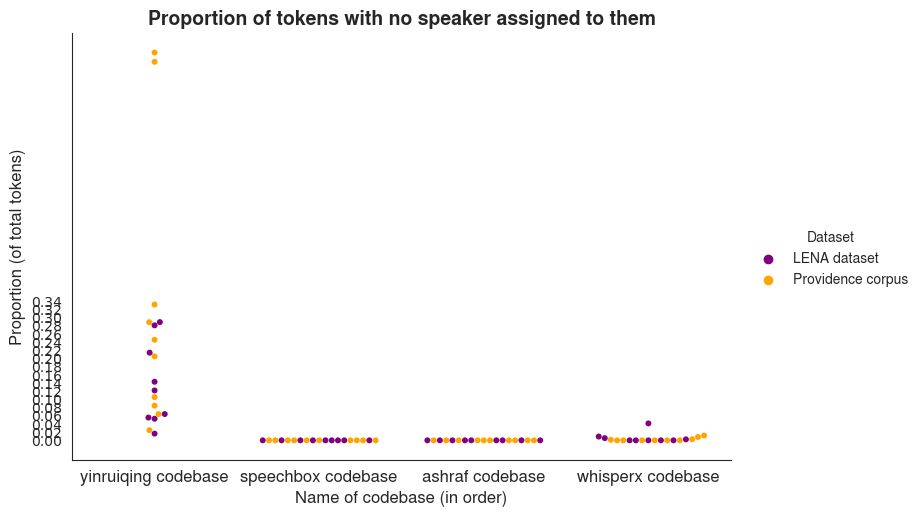

/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 2000x1000 with 0 Axes>

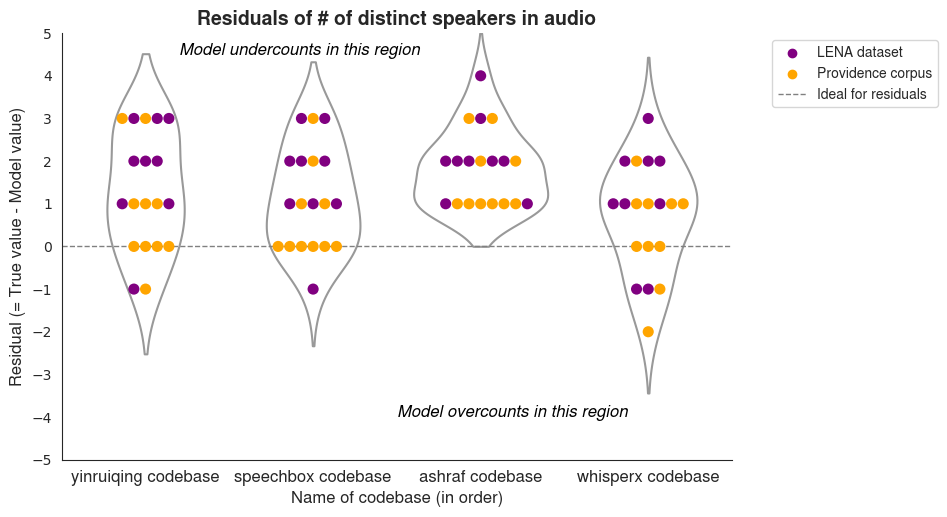

/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

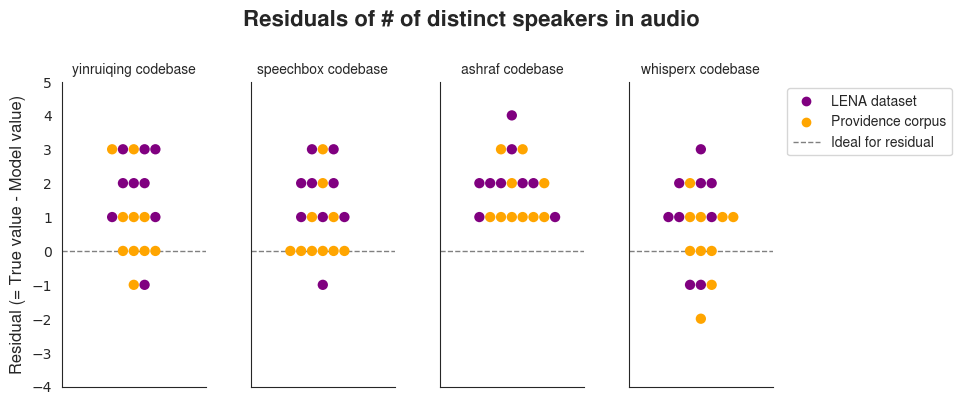

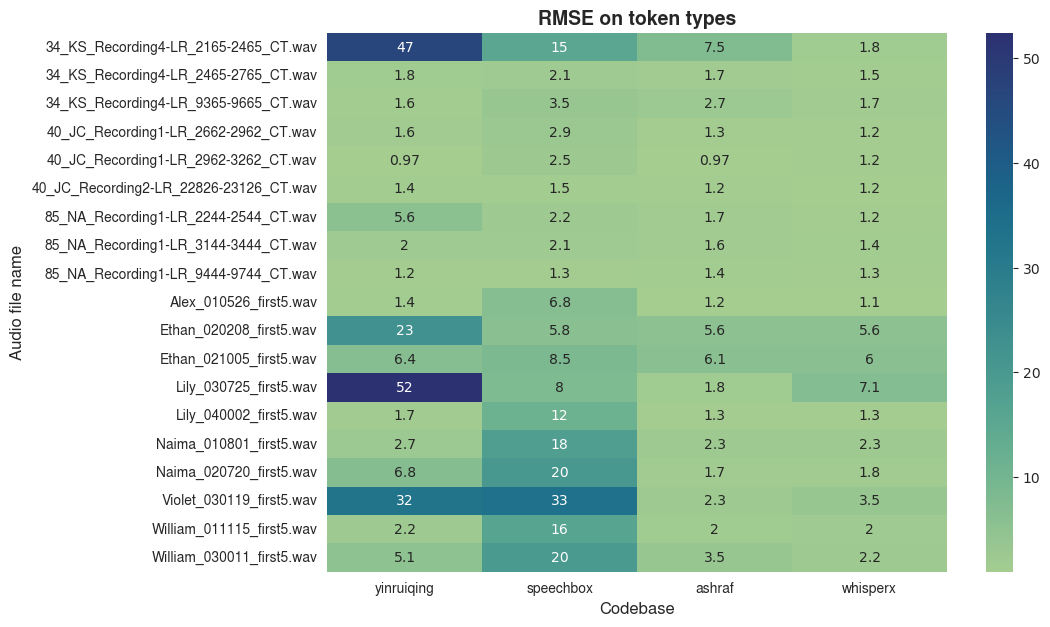

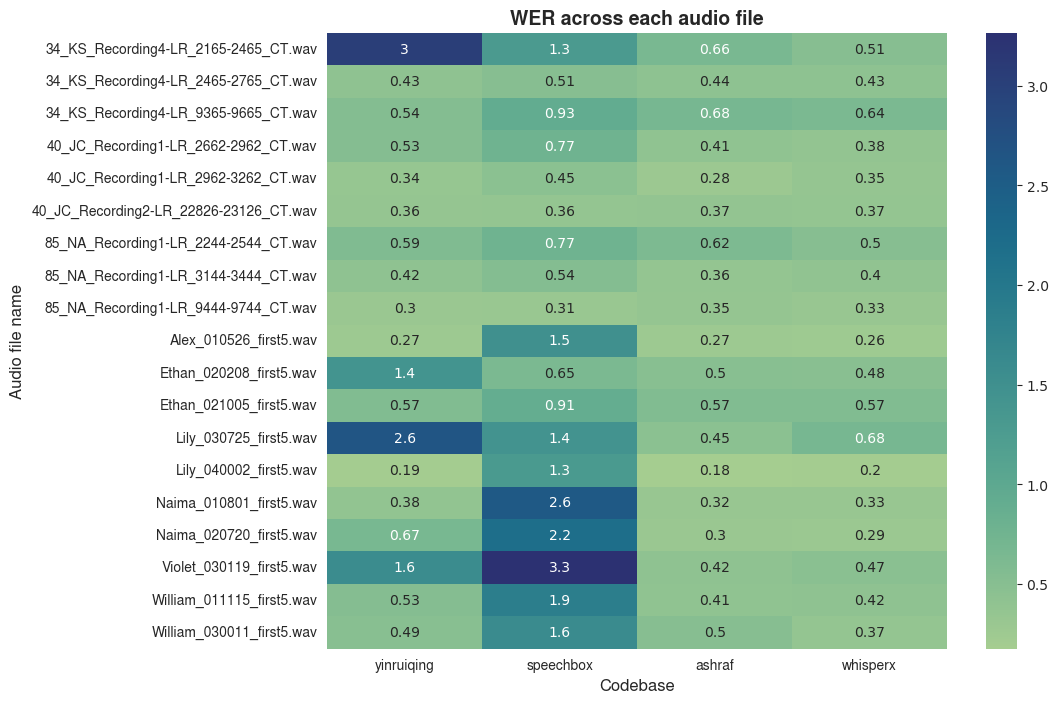

/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

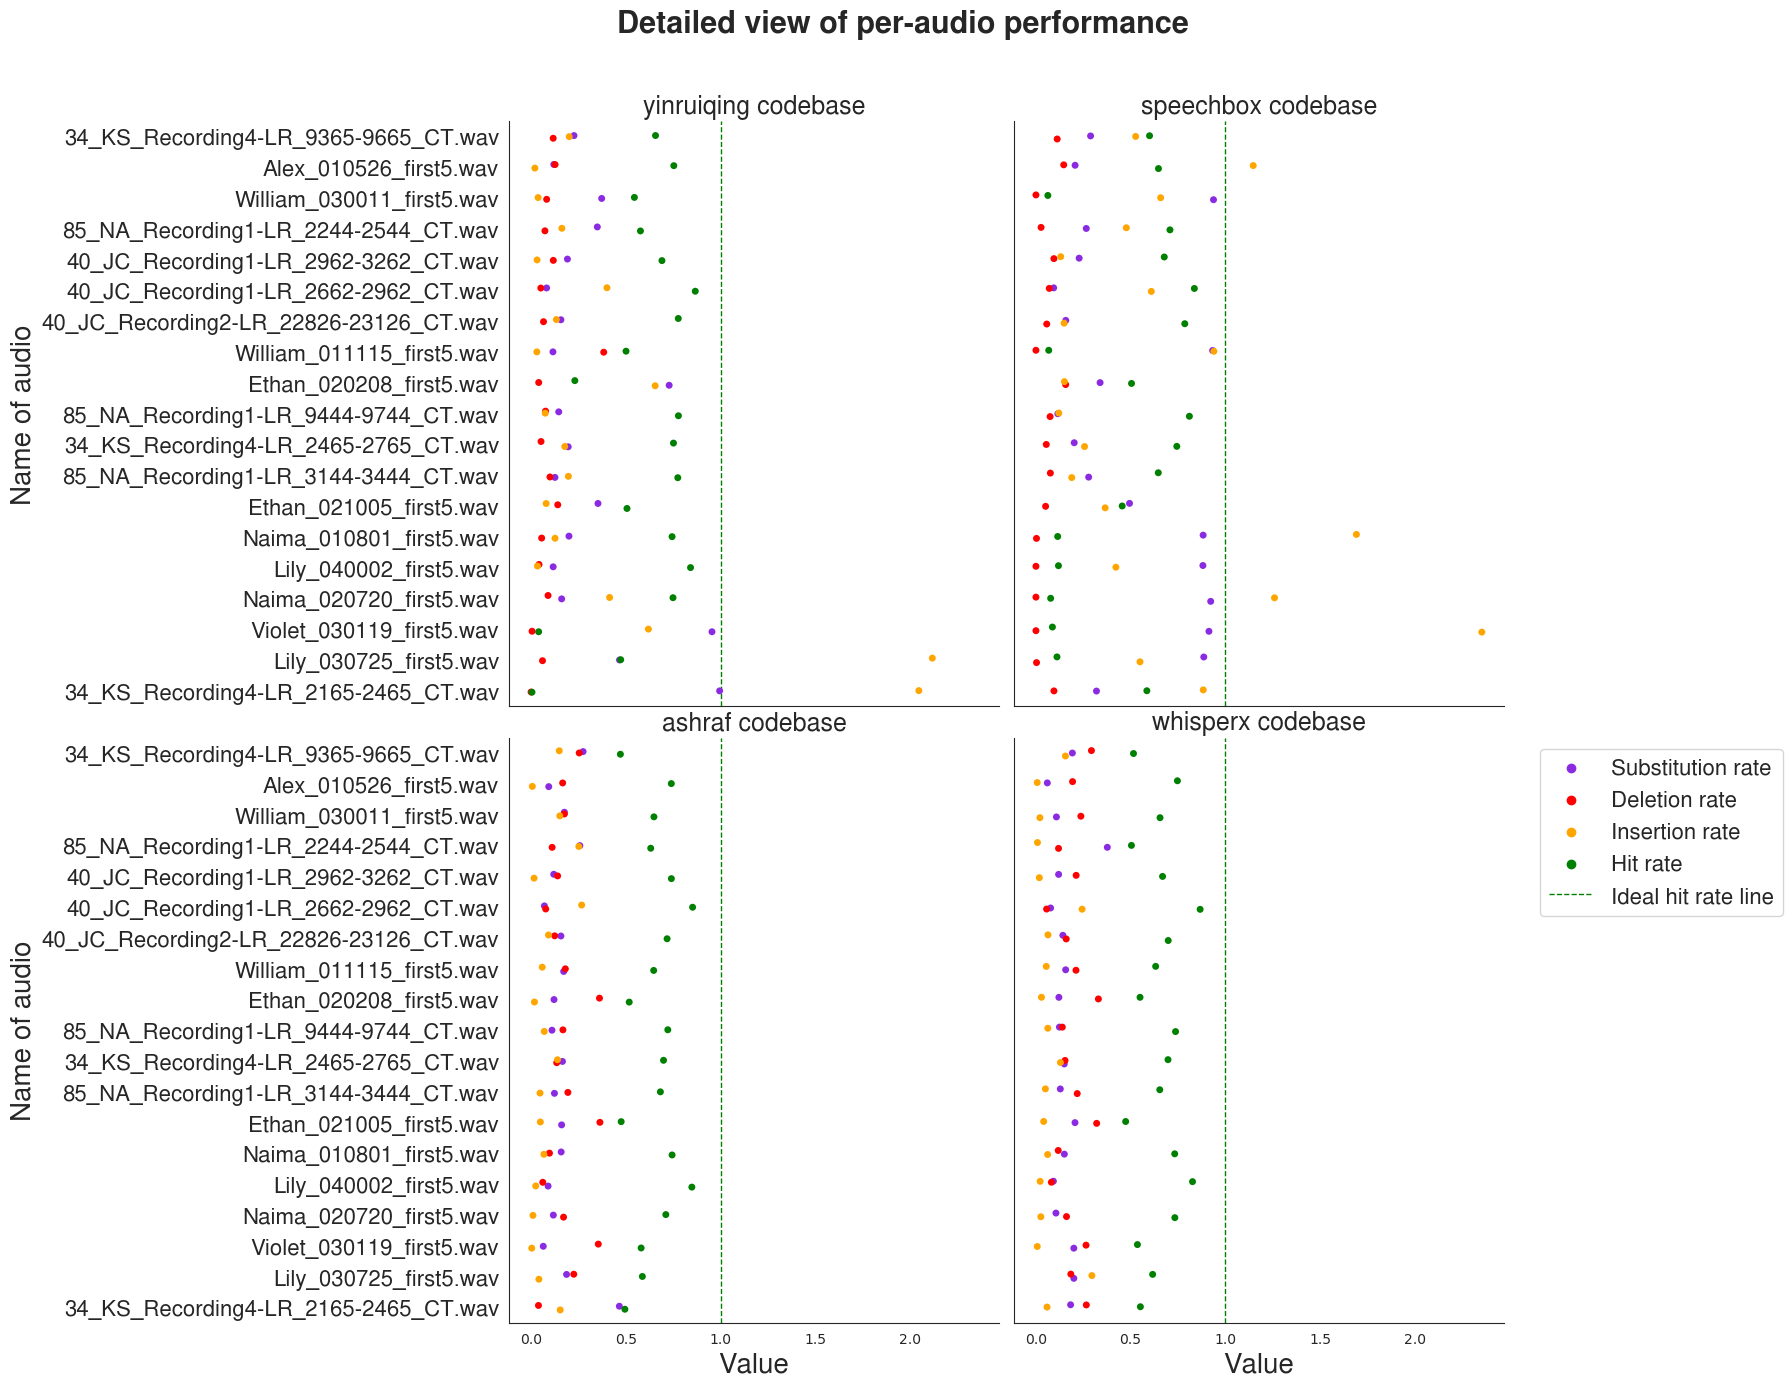

/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 5.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 5.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Figure size 640x480 with 0 Axes>

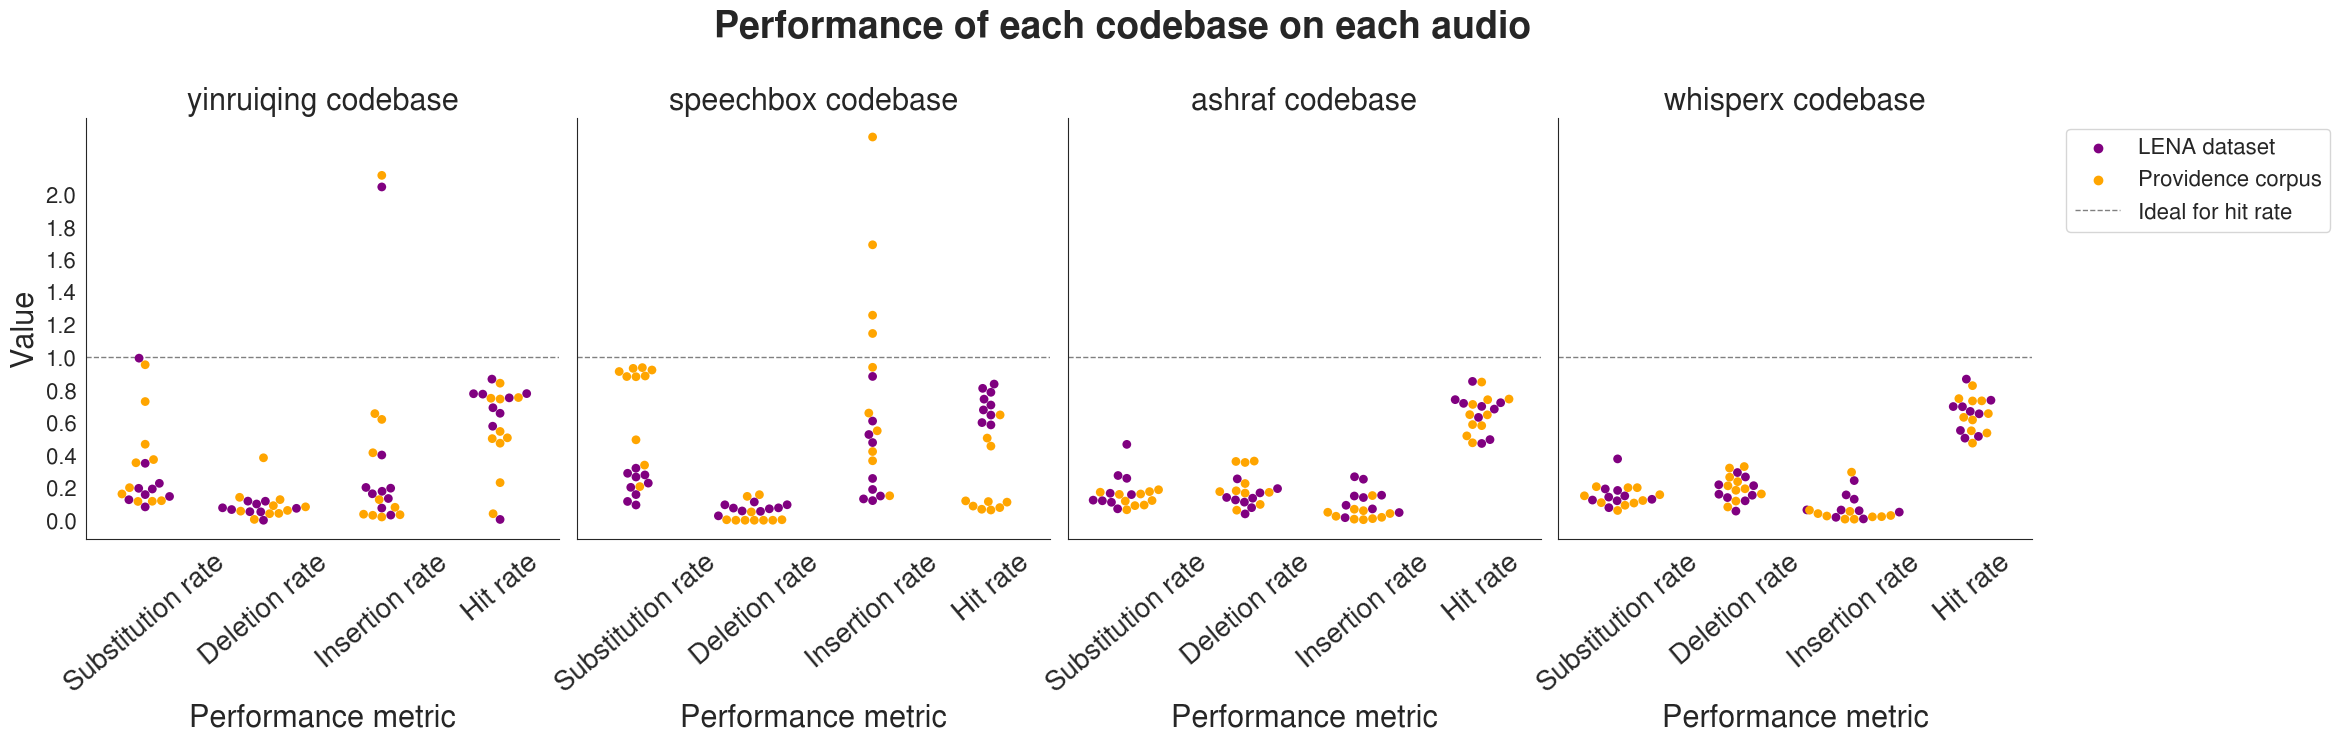

/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

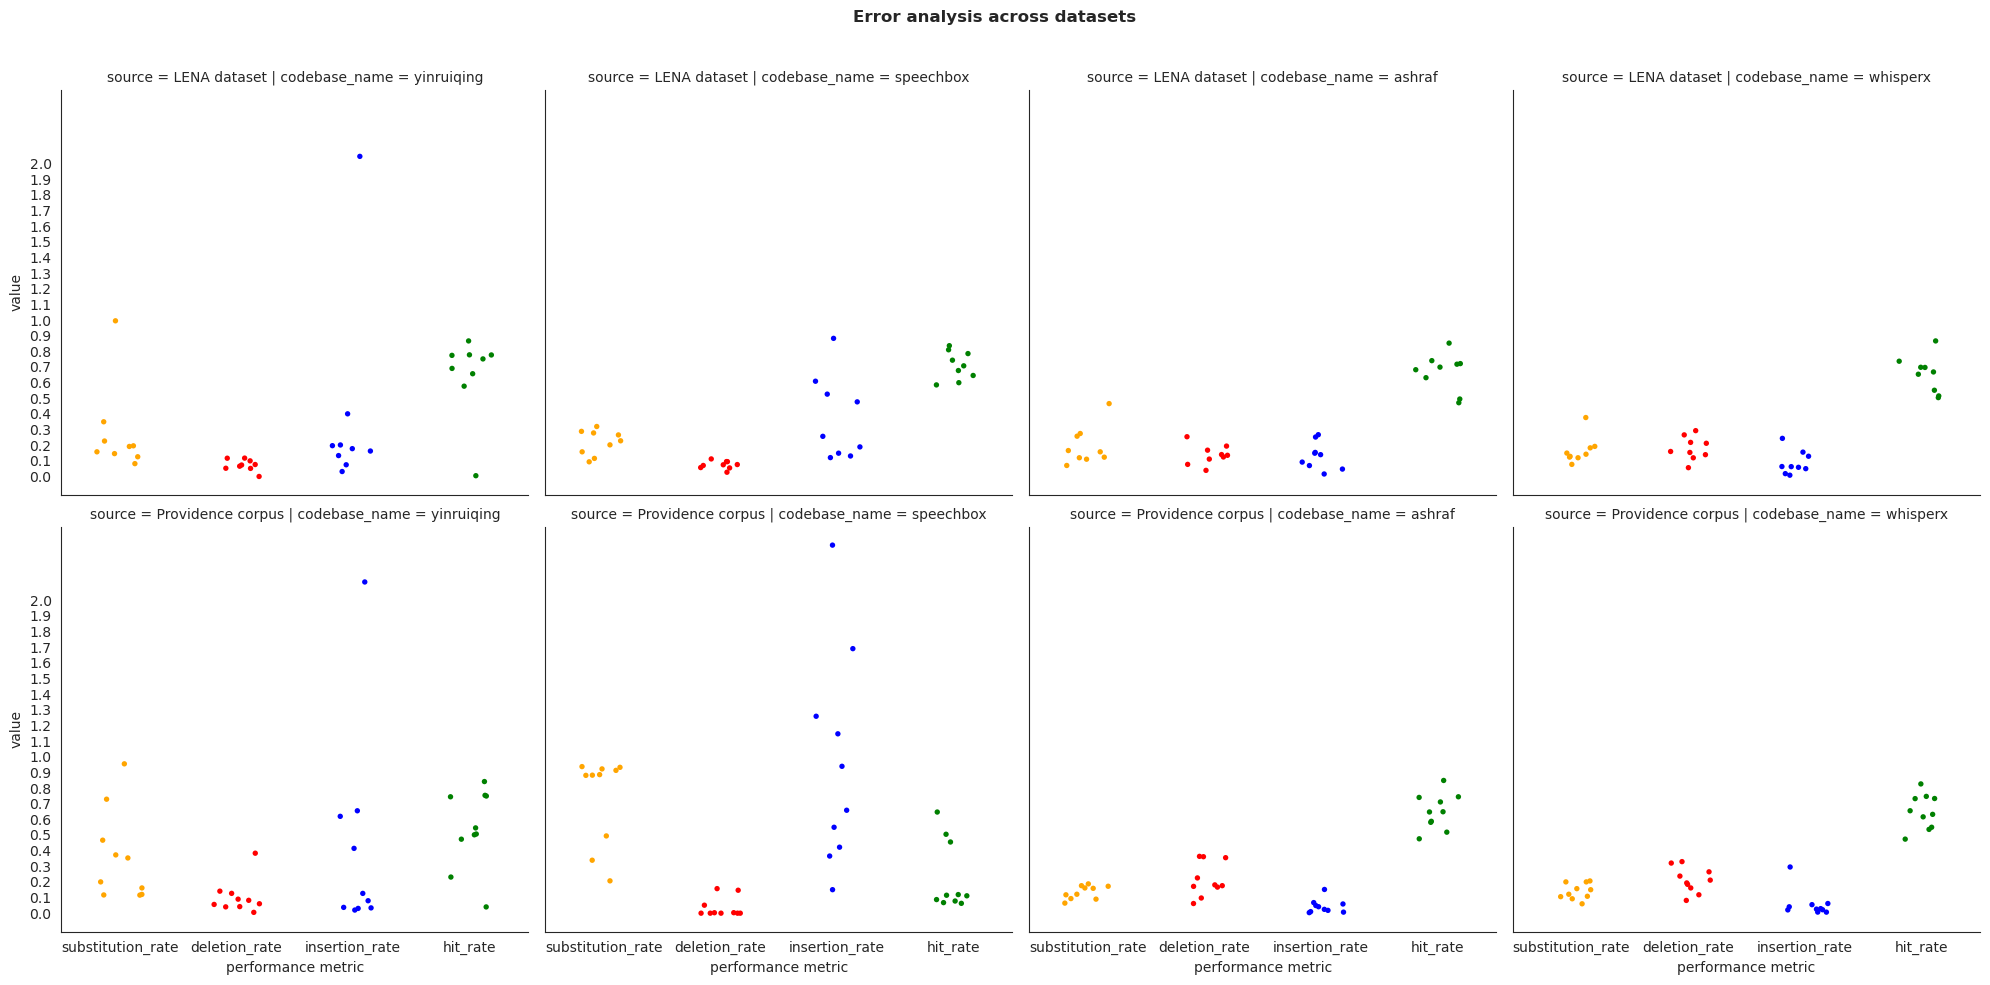

In [42]:
saveMyPlots('baseline-smallen-plots', '1727565010' )